<a href="https://colab.research.google.com/github/maruf9911/Analytic-projects-/blob/main/Starburst_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# plt.style.use('fivethirtyeight')
# sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df_offer = pd.read_csv('portfolio.csv')
df_offer.head()

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
df_customer = pd.read_csv('profile.csv')
df_customer.head()

,Unnamed: 0,gender,age,id,became_member_on,income
0,0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
df_transcript = pd.read_csv('transcript.csv')
df_transcript.head()

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


**Data Cleaning**

Drop the unnecessary column(s)

Column 'Unnamed: 0' is not useful hence to be dropped.

In [5]:
df_offer = df_offer.drop('Unnamed: 0', axis = 1)
df_customer = df_customer.drop('Unnamed: 0', axis = 1)
df_transcript = df_transcript.drop('Unnamed: 0', axis = 1)

checking for missing values

In [6]:
df_offer.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [7]:
df_customer.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [8]:
df_transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

There is no missing value in df_offer and df_transcript.

For df_customer, there are 2175 missing values in column gender and the same number of missing values in columnincome. 

Need to check whether these missing values are from the same observations.

In [9]:
missing_gender = df_customer[df_customer['gender'].isna()]
missing_income = df_customer[df_customer['income'].isna()]

np.sum(missing_gender['id'] == missing_income['id'])

2175

Remove rows with missing values in **df_customer**

In [10]:
id_to_remove = missing_income['id']
df_customer_no_na = df_customer[~df_customer['id'].isin(id_to_remove)]
df_customer_no_na = df_customer_no_na.reset_index(drop = True)
df_customer_no_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 579.2+ KB


In [11]:
df_offer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


Columns reward, difficulty and duration are integers (numerical).

Columns channels, offer_type and id are 'objects'. These should be double checked. The first value of these columns will be taken and their data types will be checked.

In [12]:
channels_0 = df_offer['channels'][0]
offer_type_0 = df_offer['offer_type'][0]
id_0 = df_offer['id'][0]

print('First value in column channels:', channels_0, '  --   Data type:', type(channels_0))
print('First value in column offer_type:', offer_type_0, '  --   Data type:', type(offer_type_0))
print('First value in column id:', id_0, '  --   Data type:', type(id_0))

First value in column channels: ['email', 'mobile', 'social']   --   Data type: <class 'str'>
First value in column offer_type: bogo   --   Data type: <class 'str'>
First value in column id: ae264e3637204a6fb9bb56bc8210ddfd   --   Data type: <class 'str'>


Elements in column channels are lists of promostion channels, as strings format. This should be be noted, but left intact for now.

**Check data types** in df_customer_no_na

In [13]:
df_customer_no_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 579.2+ KB


Column **became_member_on** are integers, which should be coverted to datetime type.


In [14]:
df_customer_no_na['became_member_on'] = pd.to_datetime(df_customer_no_na['became_member_on'], format = '%Y%m%d')

**Check data types** in df_transcript

In [15]:
df_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


Note in **time** is the number of hours since the the start of the promotion compaign, hence int64 is the proper type.

This column name can be misleading, hence will be changedd to more a more intuitive one **hours_since_start**.

In [16]:
# Rename column `time`
df_transcript.rename(columns = {'time' : 'hours_since_start'}, inplace = True)
df_transcript.head(1)

,person,event,value,hours_since_start
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


In [17]:
# Check data type of column `value`
type(df_transcript['value'][0])

str

**Transform df_offer**

Add an alias to each offer for easier recognition and referencing.

In [18]:
# Sort df offers
df_offer = df_offer.sort_values(['offer_type', 'difficulty']).reset_index(drop = True)

# Add column `offer_alias`
from string import ascii_uppercase
df_offer['offer_alias'] = [ascii_uppercase[i] for i in range(df_offer.shape[0])]
df_offer

,reward,channels,difficulty,duration,offer_type,id,offer_alias
0,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,A
1,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,B
2,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,C
3,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,D
4,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,E
5,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,F
6,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,G
7,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,H
8,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,I
9,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,J


Transform **df_transcript**

Elements of column value are dictionaries as strings. I will separate the keys and the values and place them into two columns for easier manipulation.

In [19]:
# Elements in value_columns are strings. Convert them to dictionaries
value_column = df_transcript['value']
value_column = value_column.apply(eval)
value_column[:3]

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
Name: value, dtype: object

In [20]:
# Extract the keys
dictionary_key_column = [list(d.keys())[0] for d in value_column]
# Extract the values
dictionary_value_column = [list(d.values())[0] for d in value_column]
# Create a df containing the keys and values of the dictionary elements of `value_column`
value_column_split = pd.DataFrame(columns = ['dict_key', 'dict_value'])
value_column_split['dict_key'] = dictionary_key_column
value_column_split['dict_value'] = dictionary_value_column
value_column_split.head(3)

,dict_key,dict_value
0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer id,2906b810c7d4411798c6938adc9daaa5


In [21]:
# Replace `value` column with df `value_column_split`
df_transcript_value_mod = df_transcript.drop('value', axis = 1)
df_transcript_value_mod = pd.concat([df_transcript_value_mod, value_column_split], axis = 1)

In [22]:
# Reorder columns
df_transcript_value_mod.columns.values

array(['person', 'event', 'hours_since_start', 'dict_key', 'dict_value'],
      dtype=object)

In [23]:
col_names = ['person', 'event', 'dict_key', 'dict_value', 'hours_since_start']
df_transcript_value_mod = df_transcript_value_mod[col_names]
df_transcript_value_mod.sample(3)

,person,event,dict_key,dict_value,hours_since_start
260619,884e591b217642cda0f8d69eda127a5f,offer viewed,offer id,2298d6c36e964ae4a3e7e9706d1fb8c2,576
156861,66ecd4054d85452fbdc84086586d7203,offer received,offer id,ae264e3637204a6fb9bb56bc8210ddfd,408
228265,af3e4f55f3f44cf883289857d51d2678,offer viewed,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,528


In [24]:
offers = df_offer.copy()
customers = df_customer_no_na.copy()
transcripts = df_transcript_value_mod.copy()

**Exploratory Data Analysis (EDA)**


**EDA on customer profile data**

Exploratory Data Analysis (EDA) on customer profile data will simply focus on describing the data with univariate analysis. Customer profile data will be looked at again when merged with customer behavior data ( df transcripts) in a later section.

**Univariate Analysis** - gender

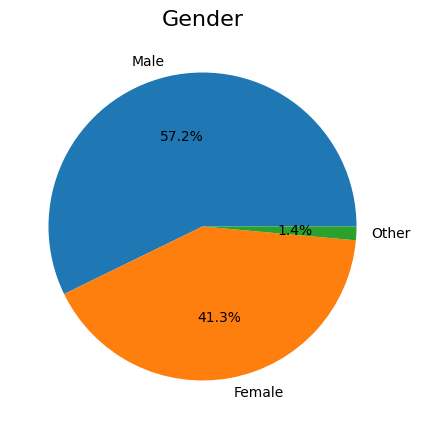

In [25]:
wedge_size =  df_customer_no_na['gender'].value_counts()
wedge_label = ['Male', 'Female', 'Other']
plt.figure(figsize = (5,5))
plt.pie(x = wedge_size, labels = wedge_label, autopct = '%1.1f%%')
plt.title('Gender', fontsize = 16)
plt.show()

**Observations**

 There are more males (57.2%) than females (41.3%) customers, and a small share (1.4%) of customers of other genders.

**Univariate Analysis** - age

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64


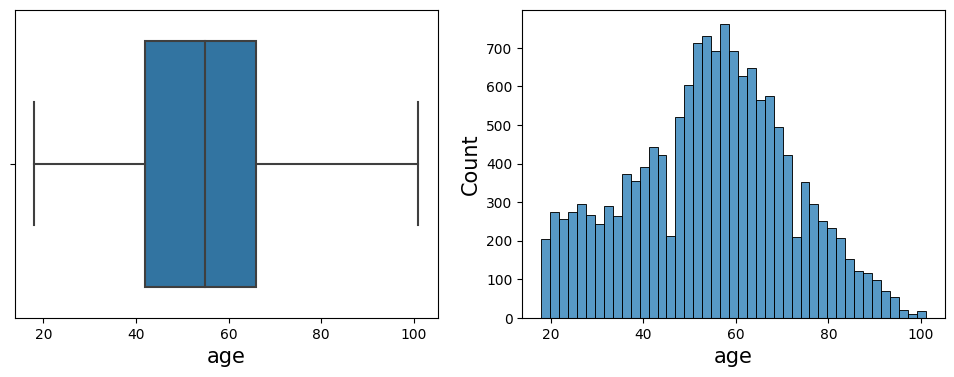

In [26]:
fig, axs = plt.subplots(1,2, figsize = (12,4))
sns.boxplot(data = customers, x = 'age', ax = axs[0])
sns.histplot(data = customers, x = 'age', ax = axs[1])
axs[0].xaxis.label.set_size(15)
axs[1].xaxis.label.set_size(15)
axs[1].yaxis.label.set_size(15)

print(customers['age'].describe())

**Observations**

The youngest customer is 18 years old and the oldest is 101 years old.

The age of the customers roughly follows a normal distribution with the mean and the standard deviation equal to 54 and 17.

Next, I will divide customers into age groups.

**Divide customers into age groups**

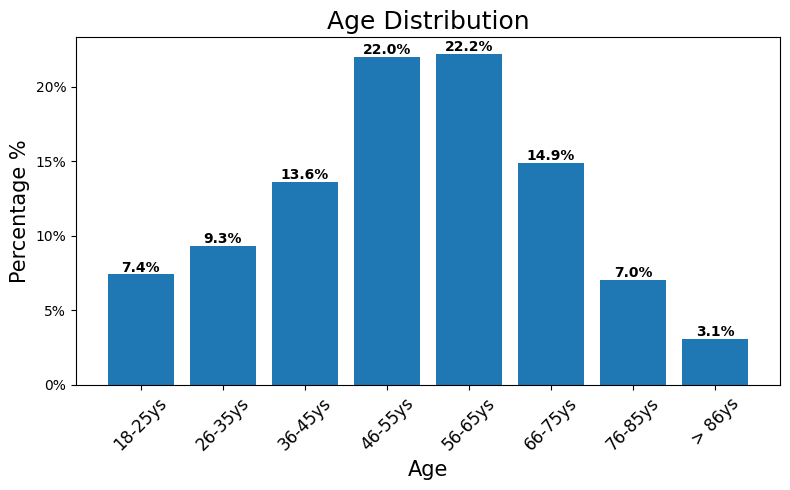

In [27]:
# Create a new column `age_group`
age_group = pd.cut(customers['age'],
      bins = [customers['age'].min(), 26, 36, 46, 56, 66, 76, 86, customers['age'].max()],
      labels = ['18-25ys', '26-35ys', '36-45ys', '46-55ys', '56-65ys', '66-75ys', '76-85ys', '> 86ys'])
customers['age_group'] = age_group

# Visualize customers by age groups
age_group_percentage = (customers.value_counts('age_group').sort_index() / customers.shape[0] * 100).round(1)
plt.figure(figsize = (8, 5))
yticks = np.arange(0,25,5)
yticklabels = [str(y) + '%' for y in yticks]
plt.yticks(yticks, labels = yticklabels)
plt.xticks(rotation = 45, fontsize = 12)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Percentage %', fontsize = 15)
plt.title('Age Distribution', fontsize = 18)

bar_plot = plt.bar(x = age_group_percentage.index.values, height = age_group_percentage)
for i,bar in enumerate(bar_plot.patches):
    x, y = bar.get_xy()
    plt.text(x+bar.get_width()/2, y+bar.get_height()+0.2,
            str(age_group_percentage[i]) + '%',
            ha = 'center', weight = 'bold')

plt.tight_layout()
plt.show()

**Observations**

The largest age group of customers is 56-65 years olds, closely followed by age group 46-55 years olds. The third largest age group is 66-75 years olds.

Top 3 age groups account for approximately 60% of customers.

This makes sense as people between 46 - 75 years old tend to be less busy than younger people, therefore have more time to visit cafes. 

They also tend to have better mobility than more senior people (above 75 years old), therefore are more likely to be our customers.

It would be very interesing to investigate how age affects customers response to offers and their purchasing habbits. This will be investigated in a later section.

**Univariate Analysis - income**

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


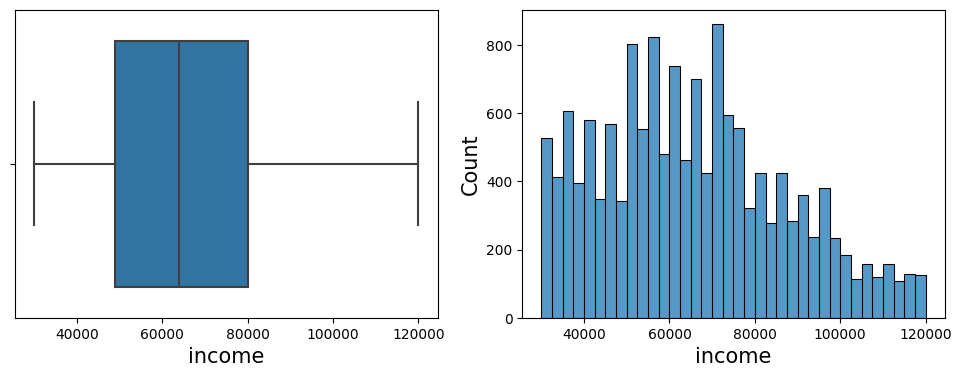

In [28]:
fig, axs = plt.subplots(1,2, figsize = (12,4))
sns.boxplot(data = customers, x = 'income', ax = axs[0])
sns.histplot(data = customers, x = 'income', ax = axs[1])
axs[0].xaxis.label.set_size(15)
axs[1].xaxis.label.set_size(15)
axs[1].yaxis.label.set_size(15)

print(customers['income'].describe())

**Divide customers into income groups**

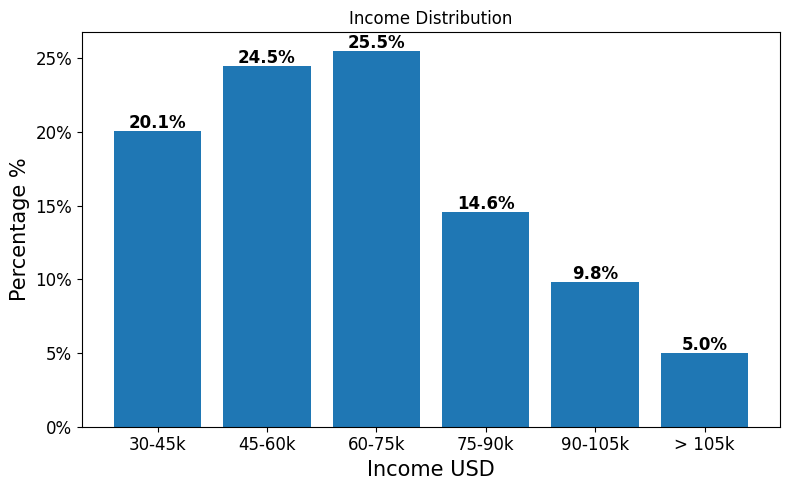

In [29]:
# Create a new column `income_group`
income_group = pd.cut(customers['income'],
      bins = [customers['income'].min(), 45000, 60000, 75000, 90000, 105000, customers['income'].max()],
      labels = ['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '> 105k'])
customers['income_group'] = income_group

# Visualize customers by income groups
income_group_percentage = (customers.value_counts('income_group').sort_index() / customers.shape[0] * 100).round(1)
plt.figure(figsize = (8, 5))
yticks = np.arange(0,30,5)
yticklabels = [str(y) + '%' for y in yticks]
plt.yticks(yticks, labels = yticklabels, fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlabel('Income USD', fontsize = 15)
plt.ylabel('Percentage %', fontsize = 15)
plt.title('Income Distribution')

bar_plot = plt.bar(x = income_group_percentage.index.values, height = income_group_percentage)
for i,bar in enumerate(bar_plot.patches):
    x, y = bar.get_xy()
    plt.text(x+bar.get_width()/2, y+bar.get_height()+0.2,
            str(income_group_percentage[i]) + '%',
            ha = 'center', weight = 'bold', fontsize = 12)

plt.tight_layout()
plt.show()

**Observations:**

Income of customers has a range of 30k to 120k, with an average of 65.4k.

Top 2 income groups consist of customers with annaul income of 60-75k and 45-60k. These account for approximately 50% of customers.

The income distribution among the customers may, to a large extent, in line with that over the whole population, except that people with extremely low income might find it hard to afford regular cafe visits, while people with extremely high income may prefer other ways to enjoy their coffee.

I will explore how income affects customer response to offers and their spendings in a later section.

Univariate Analysis - **became_member_on**

In [30]:
# Create a new df focusing on the time customers became members
df_member = customers[['id', 'became_member_on']]

# Add columns `year`, `month`, `day_of_week`
df_member = df_member.assign(year = df_member.became_member_on.dt.year,
                             month = df_member.became_member_on.dt.month,
                             day = df_member.became_member_on.dt.day,
                             month_name = df_member.became_member_on.dt.month_name(),
                             day_of_week = df_member.became_member_on.dt.weekday,
                             day_name = df_member.became_member_on.dt.day_name())
df_member.head(3)

,id,became_member_on,year,month,day,month_name,day_of_week,day_name
0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,2017,7,15,July,5,Saturday
1,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,2017,5,9,May,1,Tuesday
2,e2127556f4f64592b11af22de27a7932,2018-04-26,2018,4,26,April,3,Thursday


**Member growth by year**

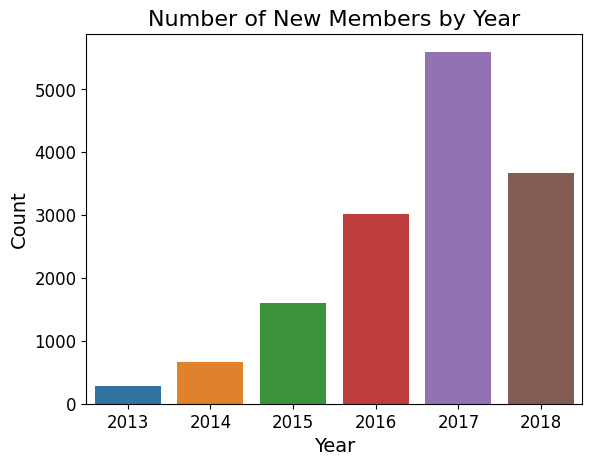

In [31]:
sns.countplot(data = df_member, x = 'year')
plt.title('Number of New Members by Year', fontsize = 16)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.xlabel('Year', fontsize = 14); plt.ylabel('Count', fontsize = 14)
plt.show()

**Daily member growth**

In [32]:
# Create a time series with the number of new member on each day
p = df_member.value_counts('became_member_on').sort_index()
df_member_growth = pd.DataFrame(index = p.index.values, data = p.values, columns = ['Number of New Members'])

In [33]:
# There are four phases with clearly different daily growth
phase_1 = df_member_growth.loc['2013-july': '2015-july']
len_phase_1 = phase_1.shape[0]
mean_phase_1 = phase_1.mean().values

phase_2 = df_member_growth.loc['2015-august': '2017-july']
len_phase_2 = phase_2.shape[0]
mean_phase_2 = phase_2.mean().values

phase_3 = df_member_growth.loc['2017-august': '2018-jan']
len_phase_3 = phase_3.shape[0]
mean_phase_3 = phase_3.mean().values

phase_4 = df_member_growth.loc['2018-feb': '2018-july']
len_phase_4 = phase_4.shape[0]
mean_phase_4 = phase_4.mean().values

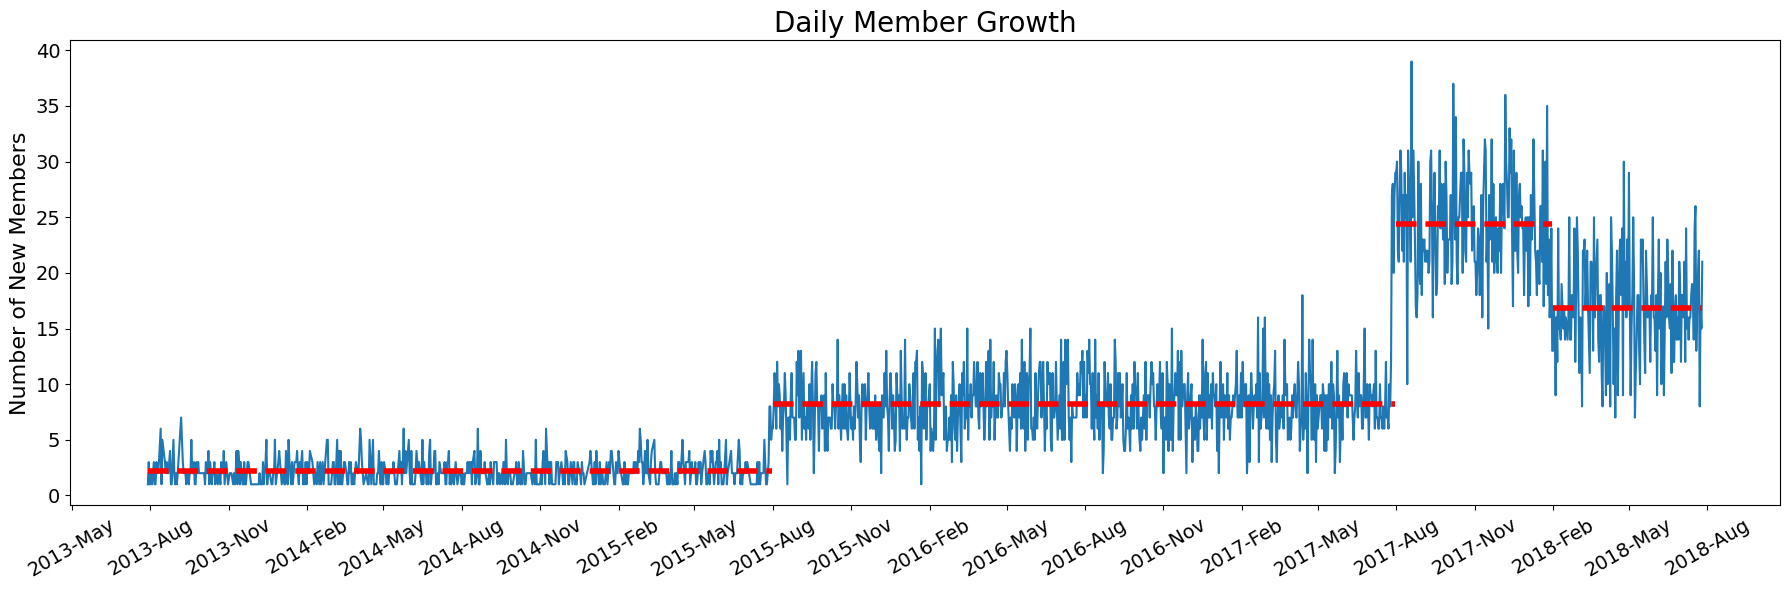

In [34]:
# Visualize
plt.figure(figsize = (18,6))
ax = sns.lineplot(x = df_member_growth.index.values, y = df_member_growth['Number of New Members'])
date_format = mdates.DateFormatter('%Y-%b')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))

plt.plot(phase_1.index.values, np.ones(len_phase_1)*mean_phase_1, '--r', lw = 4)
plt.plot(phase_2.index.values, np.ones(len_phase_2)*mean_phase_2, '--r', lw = 4)
plt.plot(phase_3.index.values, np.ones(len_phase_3)*mean_phase_3, '--r', lw = 4)
plt.plot(phase_4.index.values, np.ones(len_phase_4)*mean_phase_4, '--r', lw = 4)

plt.xticks(text = ax.xaxis.get_label(), fontsize = 14, rotation = 30)
plt.yticks(text = ax.yaxis.get_label(), fontsize = 14)
plt.ylabel('Number of New Members', fontsize = 16)
plt.title('Daily Member Growth', fontsize = 20)
plt.tight_layout()
plt.show()

**Observations:**

The data contains customers became members from July 2013 to July 2018.

Very few customers (~2.2) chose to become a member from 2013 to mid-2015.

The number of new members started to pick up from mid-2015 and really took off from mid-2017. The company must have had some sucessful compaigns around mid of 2015 and mid of 2017 that drastically boosted member growth.

However, from early 2018 the daily number growth dropped by 31% (from 24.4 to 16.8). Maybe some new strategies were applied then and had a negative impact on the member growth.

Next I will explore whether there were specific months in a year or days in a week that people were more likely to sign up.

**Member growth by Month**

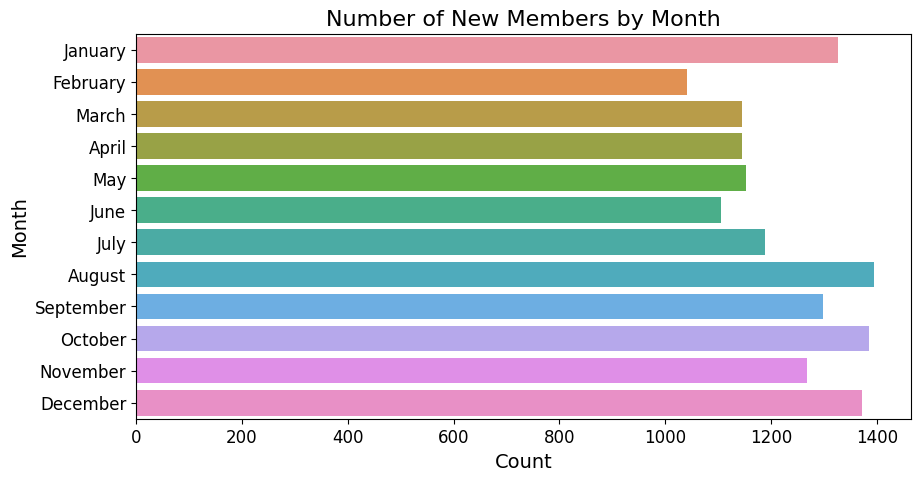

In [35]:
plt.figure(figsize = (10,5))
sns.countplot(data = df_member.sort_values('month'), y = 'month_name')
plt.title('Number of New Members by Month', fontsize = 16)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.xlabel('Count', fontsize = 14); plt.ylabel('Month', fontsize = 14)
plt.show()

**Member growth by weekday**

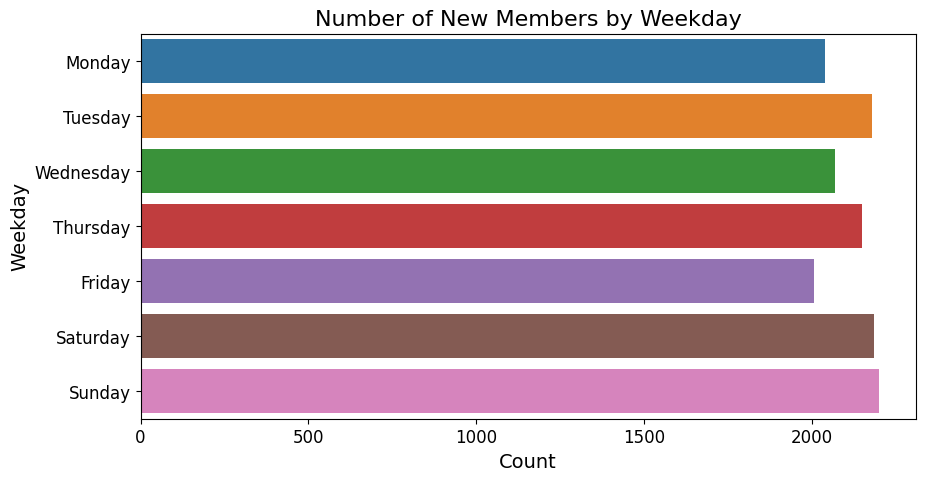

In [36]:
plt.figure(figsize = (10,5))
sns.countplot(data = df_member.sort_values('day_of_week'), y = 'day_name')
plt.title('Number of New Members by Weekday', fontsize = 16)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.xlabel('Count', fontsize = 14); plt.ylabel('Weekday', fontsize = 14)
plt.show()

**Observations**

The months saw most customers becoming memebrs was August, followed by October and Decemebr.

There were least new memebrs in Feburary on average.

In terms of days in a week, unsuprisingly, weekend saw the higher member growth than weekdays. Tuesday had the highest member growth among weekdays.

There were least new memebrs on Friday on average.


**Bivariate Analysis** - age vs gender

              age
gender           
F       57.544950
M       52.116690
O       54.400943


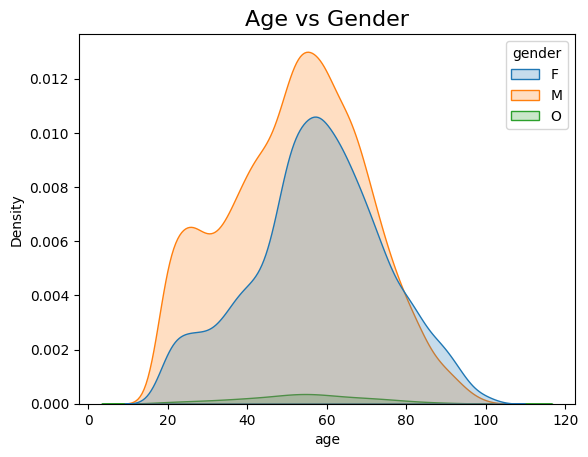

In [37]:
print(customers.groupby('gender').agg({'age': 'mean'}))
sns.kdeplot(data = customers, x = 'age', hue = 'gender', fill = True)
plt.title('Age vs Gender', fontsize = 16)
plt.show()

Observations:

The number of female and male cutomers roughly follows a normal distribution.

There is a larger proportion of young customers in males than females.

Female customers, male customers and cutomers of other genders are 57.5, 52.1 and 54.4 year old on average.

**Bivariate Analysis** - income vs gender

              income
gender              
F       71306.412139
M       61194.601603
O       63287.735849


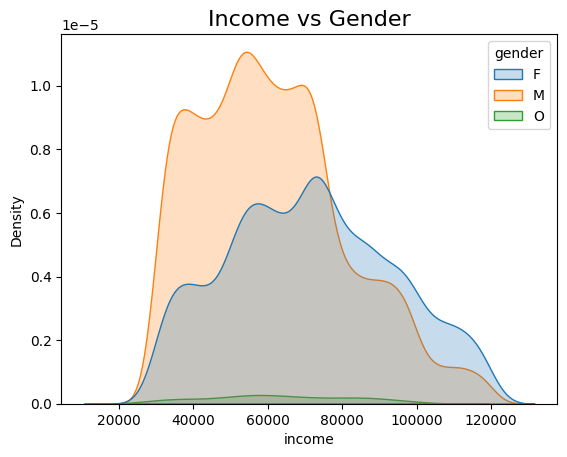

In [38]:
print(customers.groupby('gender').agg({'income': 'mean'}))
sns.kdeplot(data = customers, x = 'income', hue = 'gender', fill = True)
plt.title('Income vs Gender', fontsize = 16)
plt.show()

**Observations**

Income of female customers roughly follows a normal distribution. This indicates female customers accross the whole income range enjoys the company's products.

Income of male customers is skewed to the right. This means among the company's male customers, more people are on the lower half of the income spectrum (among customers, not among US population, as shown below).

Female customers have a much higher average income than other genders. This maybe becase they are on average older than other gender groups, assumming older customers have higher incomes (it will be checked whether this assumption is true next).

Average income of female customers, male customers and cutomers of other genders are 71k, 61k and 63k.

**Bivariate Analysis** - income vs age

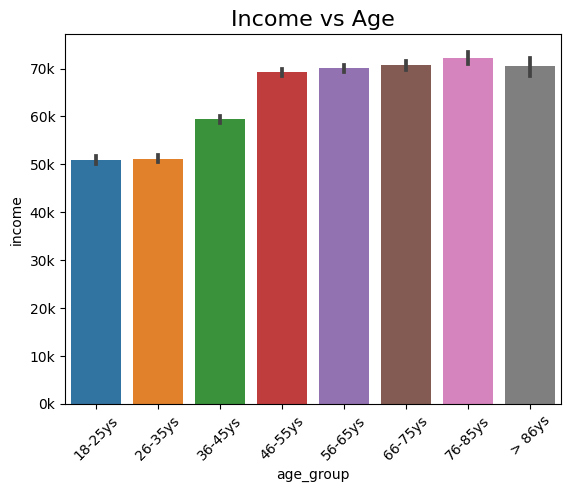

In [39]:
sns.barplot(data = customers, x = 'age_group', y = 'income')
plt.xticks(rotation = 45)
ytick_labels = [str(i) + 'k' for i in (np.arange(0, 80000, 10000) / 1000).astype(int)]
plt.yticks(np.arange(0, 80000, 10000), labels = ytick_labels)
plt.title('Income vs Age', fontsize = 16)
plt.show()

**Observations**

Customers in the two younger age groups (18-35 years old) has an average annual income of about 51k USD. The middle age groups (36-55 years old) has an average annual income of about 65k. All age groups above 56 years old have very similar average annual income of round 70k. On average, older customers of the company have higher incomes.

The company's customers in all age groups have a much higher average income than the median income of US citizens (30,119 USD in 2018).

I use the median income of 2018 as the benchmark (rather than a more recent year) because in this data set, the latest time a customer became member was July 2018. Profile data, such as income, is most likely collected when the customers signed up to become memebrs and this infomation is usually left unupdated by most people. Hence, it makes more sense to compare customer income with that of the population of the year customers last became members.

**EDA on offer data**

There are 10 offers with 5 variables in the dataset - 3 numerical and 2 categorical. I will first have a quick overview with pairplots, and then check the important variables individually.

**Pairplots of numerical variables** reward, difficuty and duration ( offer_type also shown with color)

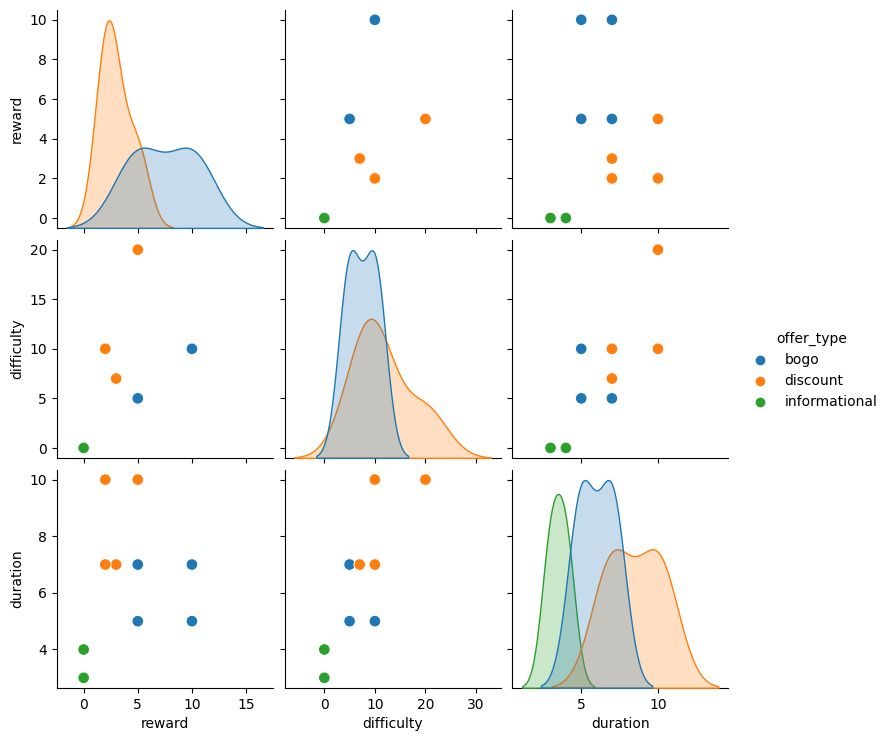

In [40]:
sns.pairplot(offers, hue = 'offer_type', 
             plot_kws = dict(marker="o", s=70),); plt.show()

**Observations**

There are 4 'bogo' offers (i.e. buy one get one), 4 'discount' offers and 2 'informational' offers.

'Discount' offers tend to have the longest duration, followed by 'bogo' offers. 'Informational' offers have the shortest duration.

'Discount' offers tend to have higher difficulty but lower rewards compared with 'bogo' offers.

Offer difficulty seems to be possitively correlated with offer reward.

Offer duration seems to negatively correlate with reward and positively correlate with difficulty, when 'informational' offers are exclued (they don't really have reward or difficulty).

The bivariate relationships are very unclear from the pairplots and will be checked shortly.

**Univariate** - channels

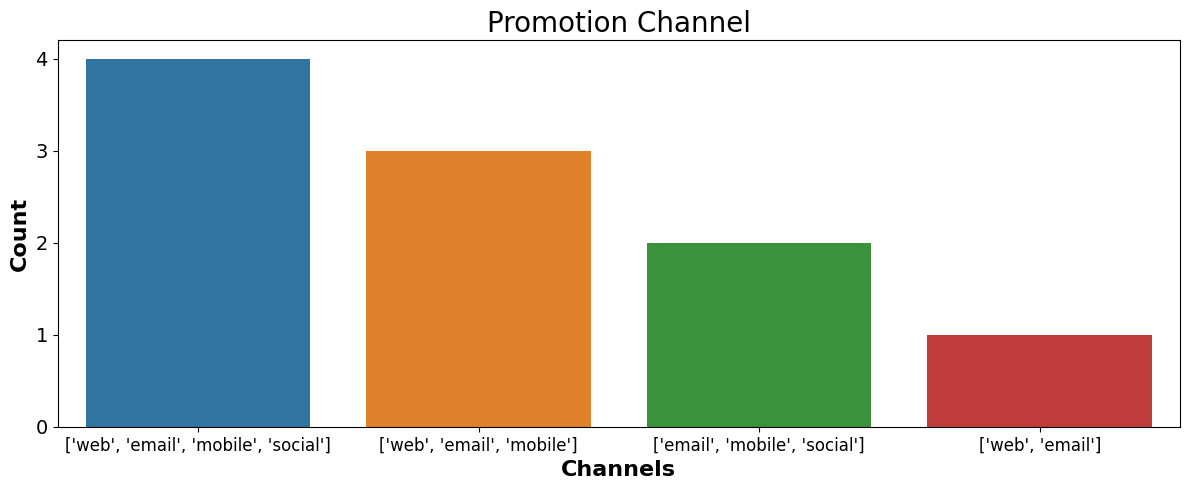

In [41]:
p = offers.value_counts('channels')
plt.figure(figsize = (12,5))
sns.barplot(x = p.index.values, y = p.values)
plt.xticks(rotation = None, fontsize = 12)
plt.yticks(np.arange(5), fontsize = 14)
plt.xlabel('Channels', fontsize = 16, fontweight = 'bold')
plt.ylabel('Count', fontsize = 16, fontweight = 'bold')
plt.title('Promotion Channel', fontsize = 20)
plt.tight_layout()
plt.show()

**Bivariate - check the correlation observed in the pairplot**

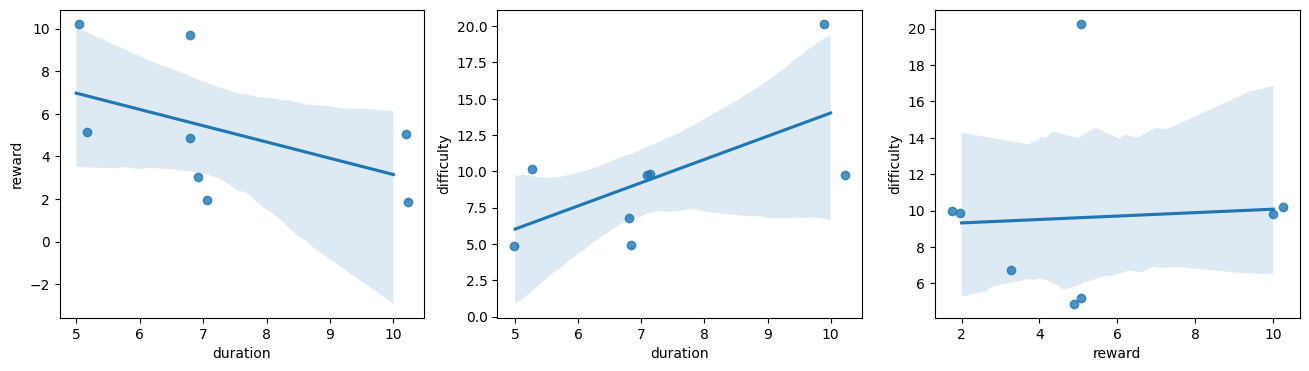

In [42]:
fig, axs = plt.subplots(1,3, figsize = (16,4))
sns.regplot(data = offers[0:8], x = 'duration', y ='reward', x_jitter = 0.3, y_jitter = 0.3, ax = axs[0])
sns.regplot(data = offers[0:8], x = 'duration', y ='difficulty', x_jitter = 0.3, y_jitter = 0.3, ax = axs[1])
sns.regplot(data = offers[0:8], x = 'reward', y ='difficulty', x_jitter = 0.3, y_jitter = 0.3, ax = axs[2])
plt.show()

**EDA on transcripts data**

**Univariate Analysis** - event

In [43]:
transcripts['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

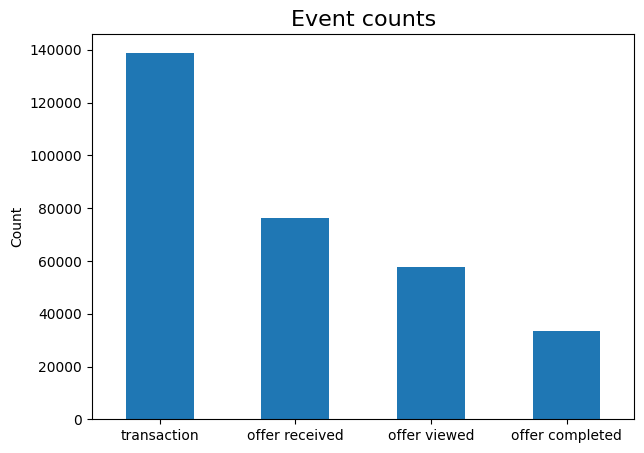

In [44]:
fig = plt.figure(figsize = (7,5))
transcripts['event'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = None)
plt.ylabel('Count')
plt.title('Event counts', fontsize = 16)
plt.show()

A sutdy on event over time

Time in this data set is given by the number of hours since the start of the campaign, rather than the actual datetime when events (offers being received, viewed, completed and transactions being made) occurred. Therefore, I will use hours_since_start as time information when analysing the occurrence of events over time, instead of using the the data set as a time series.

In [45]:
# Add column `days_since_start`
transcripts = transcripts.assign(days_since_start = transcripts['hours_since_start']/24).astype({'days_since_start': 'int64'})
print('The minimum and the maximum of column days_since_start: {} and {}'.format(transcripts['days_since_start'].min(), transcripts['days_since_start'].max()))


The minimum and the maximum of column days_since_start: 0 and 29


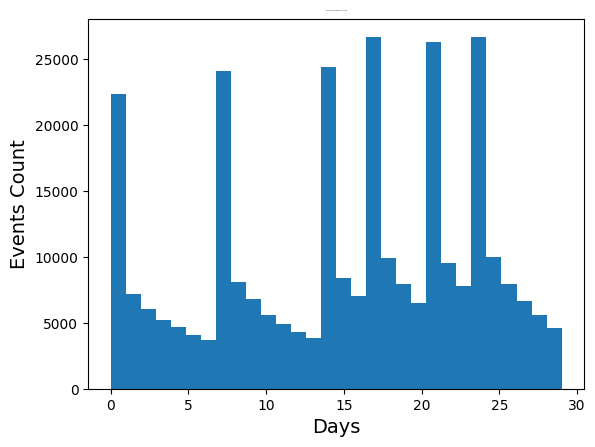

In [46]:
plt.hist(transcripts['days_since_start'], bins = 30)
plt.xlabel('Days', fontsize = 14)
plt.ylabel('Events Count', fontsize = 14)
plt.title('Events Occurrence over time', fontsize = 1)
plt.show()

It is clear from the plot that there are 6 peaks of events during the campaign. These peaks should correspond to offers being received, while other events (offers viewed, offers completed and purchases) occured afterwards over time.


This idea is briefly tested below.

In [47]:
transcripts[transcripts['event'] == 'offer received'].groupby('hours_since_start').count()

,person,event,dict_key,dict_value,days_since_start
hours_since_start,,,,,
0,12650,12650,12650,12650,12650
168,12669,12669,12669,12669,12669
336,12711,12711,12711,12711,12711
408,12778,12778,12778,12778,12778
504,12704,12704,12704,12704,12704
576,12765,12765,12765,12765,12765


event over time -** A break-down**

In [48]:
# Find how many events occurred in each hour
viewed_hourly = transcripts[transcripts['event'] == 'offer viewed'].value_counts('hours_since_start').sort_index()
completed_hourly = transcripts[transcripts['event'] == 'offer completed'].value_counts('hours_since_start').sort_index()
transaction_hourly = transcripts[transcripts['event'] == 'transaction'].value_counts('hours_since_start').sort_index()
print(len(viewed_hourly), len(completed_hourly), len(transaction_hourly))

120 120 120


The three Series record the number of hourly occurrence of each of the three event types. They all have 120 records, i.e. 120 hours. It will make plotting very easy if they actually representing the same 120 hours (since the start of the campaign).

Let's check if that is the case:

In [49]:
(viewed_hourly.index.values == completed_hourly.index.values).sum(), (completed_hourly.index.values == transaction_hourly.index.values).sum()

(120, 120)

The index of the three Series are identical, representing the same hours since the start of the campaign. The occurrence break-down over time can be easily plotted. Occurrence break-down in hours and days are both plotted below.

In [50]:
# Find how many events of each type occurred on each day from Day 0 to Day 29
received_daily = transcripts[transcripts['event'] == 'offer received'].value_counts('days_since_start').sort_index()
viewed_daily = transcripts[transcripts['event'] == 'offer viewed'].value_counts('days_since_start').sort_index()
completed_daily = transcripts[transcripts['event'] == 'offer completed'].value_counts('days_since_start').sort_index()
transaction_daily = transcripts[transcripts['event'] == 'transaction'].value_counts('days_since_start').sort_index()

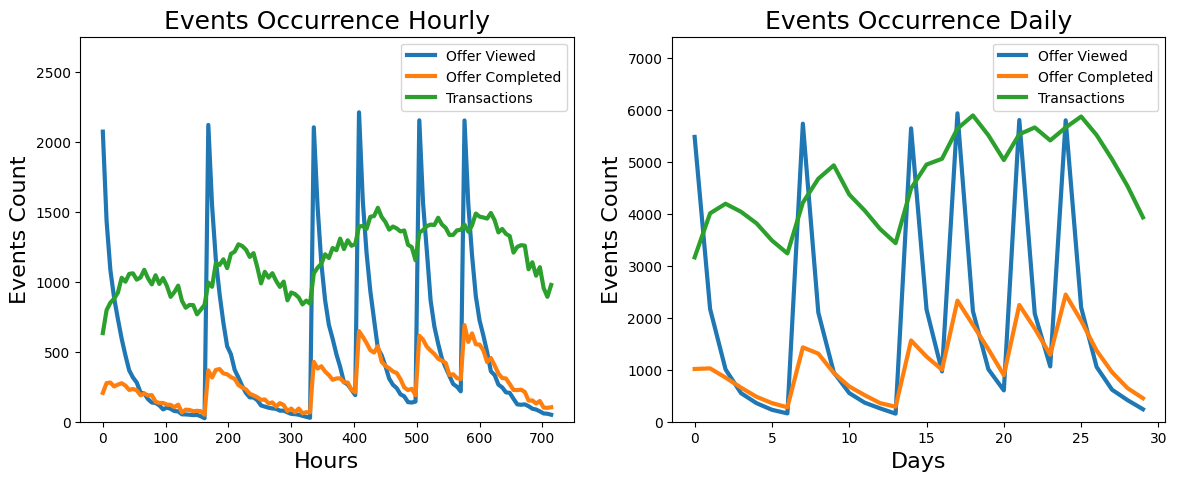

In [51]:
# Visualize
hours = viewed_hourly.index.values
fig, axs = plt.subplots(1,2, figsize = (14, 5))
# axs[0].stem(received_hourly.index.values, received_hourly, linefmt = ':k')
axs[0].plot(hours, viewed_hourly, lw = 3)
axs[0].plot(hours, completed_hourly, lw = 3)
axs[0].plot(hours, transaction_hourly, lw = 3)
axs[0].legend(['Offer Viewed', 'Offer Completed', 'Transactions'], loc = 'upper right', ncol = 1, fontsize = 10)
axs[0].set_ylim([0, 2750])
axs[0].set_xlabel('Hours', fontsize = 16)
axs[0].set_ylabel('Events Count', fontsize = 16)
axs[0].set_title('Events Occurrence Hourly', fontsize = 18)

days = np.arange(30)
# axs[1].stem(received_daily.index.values, received_daily, linefmt = ':k')
axs[1].plot(days, viewed_daily, lw = 3)
axs[1].plot(days, completed_daily, lw = 3)
axs[1].plot(days, transaction_daily, lw = 3)
axs[1].legend(['Offer Viewed', 'Offer Completed', 'Transactions'], loc = 'upper right', ncol = 1, fontsize = 10)
axs[1].set_ylim([0, 7400])
axs[1].set_xlabel('Days', fontsize = 16)
axs[1].set_ylabel('Events Count', fontsize = 16)
axs[1].set_title('Events Occurrence Daily', fontsize = 18)

plt.show()

**Which offers were the most popular?**

Merge offers and transcripts
Merge the offer data and the transcript (event only) data:

In [52]:
# Create a df that only contains events about offers
df_event = transcripts[~(transcripts['event'] == 'transaction')]

# Merge df_event with and offers
event_offer = pd.merge(df_event, offers, left_on = 'dict_value', right_on = 'id').drop('id', axis = 1)

# Reorder columns of the merged df
col_names = ['person', 'event', 'offer_alias', 'reward',
       'channels', 'difficulty', 'duration', 'offer_type', 'hours_since_start', 'days_since_start', 'dict_key', 'dict_value',]
event_offer = event_offer[col_names]

# Drop column `dict_value`, as this is offer id which is hard to identify. This information is provided by column `offer_alias`
event_offer = event_offer.drop('dict_value', axis = 1)
event_offer.sample(3)

,person,event,offer_alias,reward,channels,difficulty,duration,offer_type,hours_since_start,days_since_start,dict_key
18580,8e41b43818f144b784fc64fe8c27d3e7,offer received,H,5,"['web', 'email']",20,10,discount,168,7,offer id
73439,e61d674d2adc44c59e41458f838ba954,offer viewed,D,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,336,14,offer id
76057,992eebab42594edc966b71493316cdd0,offer received,D,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,408,17,offer id


**Overall Completion Rate** 

In [53]:
# Find out the number of time being received for each offer 
offer_received = event_offer[event_offer['event'] == 'offer received']
p0 = offer_received.value_counts('offer_alias').sort_values(ascending = False)

# Find out the number of time being completed for each offer 
offer_completed = event_offer[event_offer['event'] == 'offer completed']
p2 = offer_completed.value_counts('offer_alias').sort_values(ascending = False)

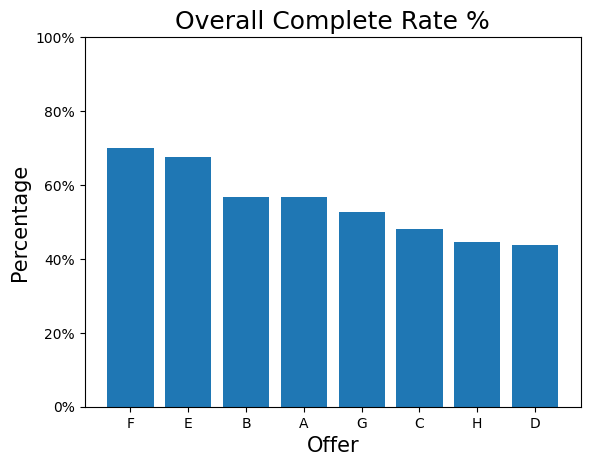

In [54]:
# Overall completion rate of each offer
overall_complete_rate = (p2.sort_index() / p0.sort_index()).sort_values(ascending = False)

# Visualize
plt.bar(x = overall_complete_rate.index.values, height = overall_complete_rate.values)
plt.title('Overall Complete Rate %', fontsize = 18)
plt.xlabel('Offer', fontsize = 15)
plt.ylabel('Percentage', fontsize = 15)
plt.yticks(np.arange(0,1.2, 0.2), labels = ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.show()

Event offer received - Were all offers received the same number of times?¶


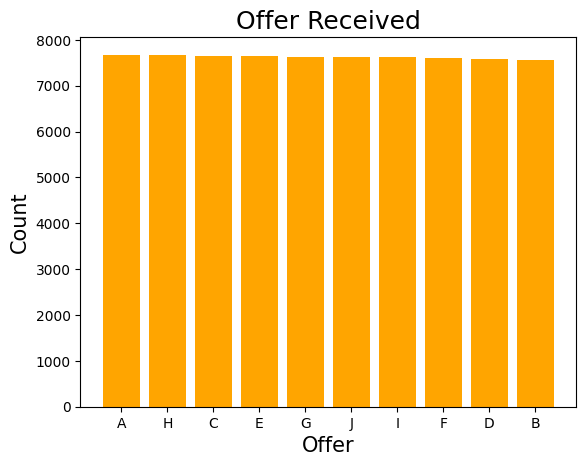

In [55]:
# offer_received = event_offer[event_offer['event'] == 'offer received']
# p0 = offer_received.value_counts('offer_alias').sort_values(ascending = False)
plt.bar(x = np.arange(len(p0)), height = p0.values, tick_label = p0.index.values, color = 'orange')
plt.title('Offer Received', fontsize = 18)
plt.xlabel('Offer', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.show()

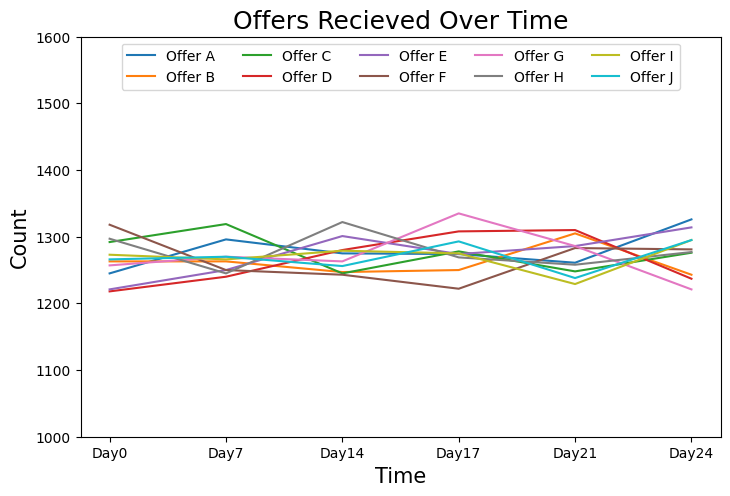

In [56]:
# Find out how many time each offer were received on each receiving day
num_offers = offers.shape[0]
each_offer_received = pd.DataFrame(index = received_daily.index.values)
for col in ascii_uppercase[:num_offers]:
    each_offer_received[col] = offer_received[offer_received['offer_alias'] == col].value_counts('days_since_start').sort_index()
each_offer_received.index = ['Day' + str(x) for x in received_daily.index.values]

# Visualize
fig = plt.figure(figsize = (8, 5))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))

for col in ascii_uppercase[:num_offers]:
    ax.plot(np.arange(6), each_offer_received[col])
    
ax.set_ylim([1000,1600])
ax.set_xticks(np.arange(6))
ax.set_xticklabels(each_offer_received.index.values)
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
legend_str = ['Offer ' + i for i in ascii_uppercase[:num_offers]]
plt.legend(legend_str, loc = 'upper center', ncol = 5, fontsize = 10)
plt.title('Offers Recieved Over Time', fontsize = 18)
plt.show()

**View Rate % - What is its most important contributor?**

In this subsection, I will try to answer questions:

Which offers had the highest view rate?

What is the most important contributor to the view rate of an offer?

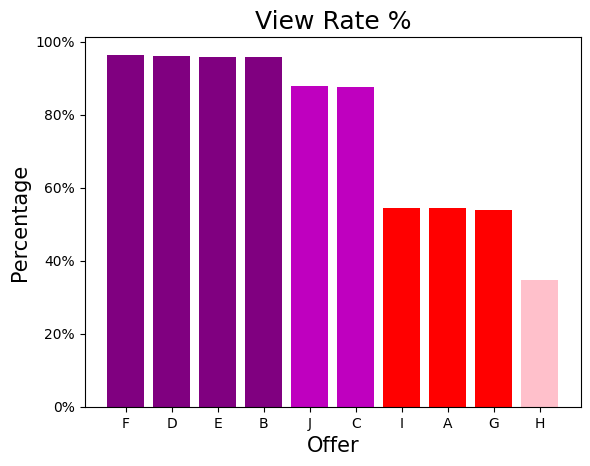

In [57]:
offer_viewed = event_offer[event_offer['event'] == 'offer viewed']
p1 = offer_viewed.value_counts('offer_alias').sort_values(ascending = False)
p1_rate = (p1.sort_index() / p0.sort_index()).sort_values(ascending = False)
plt.bar(x = np.arange(len(p1)), height = p1_rate.values, tick_label = p1_rate.index.values,
       color = ['purple', 'purple','purple', 'purple', 'm', 'm','r', 'r', 'r', 'pink'])
plt.title('View Rate %', fontsize = 18)
plt.xlabel('Offer', fontsize = 15)
plt.ylabel('Percentage', fontsize = 15)
plt.yticks(np.arange(0,1.2, 0.2), labels = ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.show()

**Completion Rate % - What is its most important contributor?**

Note the complete rate investigated in this section is calculated based on the number of offers viewed (not received). I will simply refer to it as completion rate % for simplicity.

In this subsection, I will try to answer questions?

  Which offers had the highest completion rate?

  What is the most important contributor to the completion rate?

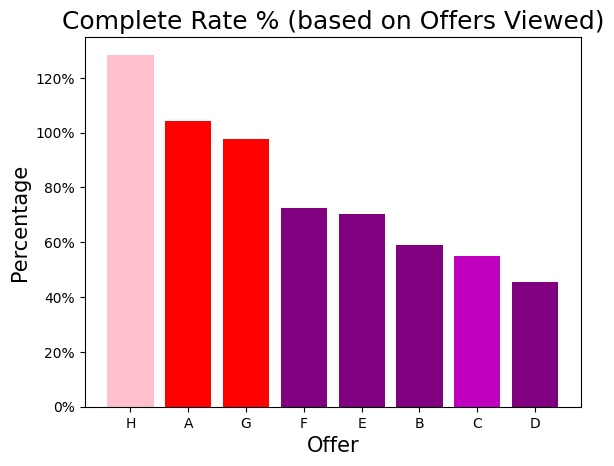

In [58]:
# offer_completed = event_offer[event_offer['event'] == 'offer completed']
p2 = offer_completed.value_counts('offer_alias').sort_values(ascending = False)

p2_rate = (p2.sort_index() / p1.sort_index()).sort_values(ascending = False)
color_list = ['pink', 'red', 'red', 'purple', 'purple', 'purple', 'm', 'purple']
plt.bar(x = p2_rate.index.values, height = p2_rate.values, color = color_list)
plt.title('Complete Rate % (based on Offers Viewed)', fontsize = 18)
plt.xlabel('Offer', fontsize = 15)
plt.ylabel('Percentage', fontsize = 15)
plt.yticks(np.arange(0,1.4, 0.2), labels = ['0%', '20%', '40%', '60%', '80%', '100%', '120%'])
plt.show()

**Extracting Customer behavior Features**

Features for clusteing will be extracted including, for each customer, number of offers received, number of offers viewed, number of offers completed, number of transactions made (during the month of campiagn) and total amount of money spent.

In [59]:
# Create an empty df with columns needed
customer_behavior = pd.DataFrame(columns = ['person', 'num_received', 'num_viewed', 'num_completed', 'num_transactions', 'money_spent'])

In [60]:
# Remove rows of customers with missing gender and income
id_to_remove = missing_income['id']
transcripts_filtered = transcripts[~transcripts['person'].isin(id_to_remove)].reset_index(drop = True)

# Add data to `person`, ordered in ascending order
customer_behavior['person'] = transcripts_filtered.value_counts('person').sort_index().index.values

In [61]:
# Aggregate df transcripts
transcripts_filtered = transcripts_filtered.sort_values('person')
transcripts_grouped = transcripts_filtered.groupby(['person', 'event']).count()
transcripts_grouped.head()

dict_key  dict_value  \
person                           event                                   
0009655768c64bdeb2e877511632db8f offer completed         3           3   
                                 offer received          5           5   
                                 offer viewed            4           4   
                                 transaction             8           8   
0011e0d4e6b944f998e987f904e8c1e5 offer completed         3           3   

                                                  hours_since_start  \
person                           event                                
0009655768c64bdeb2e877511632db8f offer completed                  3   
                                 offer received                   5   
                                 offer viewed                     4   
                                 transaction                      8   
0011e0d4e6b944f998e987f904e8c1e5 offer completed                  3   

                                                  days_since_start  
person                           event                              
0009655768c64bdeb2e877511632db8f offer completed                 3  
                                 offer received                  5  
                                 offer viewed                    4  
                                 transaction                     8  
0011e0d4e6b944f998e987f904e8c1e5 offer completed                 3

In [62]:
# Set `person` as index for easy slicing
customer_behavior.set_index('person', inplace = True)

# Add data to `num_received`, `num_viewed`, `num_completed` and `num_transactions`
for person_id in customer_behavior.index.values:
    if (person_id, 'offer received') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_received'] = transcripts_grouped.loc[(person_id, 'offer received'), 'dict_key']
    if (person_id, 'offer viewed') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_viewed'] = transcripts_grouped.loc[(person_id, 'offer viewed'), 'dict_key']
    if (person_id, 'offer completed') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_completed'] = transcripts_grouped.loc[(person_id, 'offer completed'), 'dict_key']
    if (person_id, 'transaction') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_transactions'] = transcripts_grouped.loc[(person_id, 'transaction'), 'dict_key']

In [63]:
# Calculate how much money each customer spent during the month of the campaign
money_spent = transcripts_filtered[transcripts_filtered['event'] == 'transaction'].groupby('person').agg({'dict_value': 'sum'})

# Add to `money_spent`
customer_behavior['money_spent'] = money_spent
customer_behavior.head(3)

,num_received,num_viewed,num_completed,num_transactions,money_spent
person,,,,,
0009655768c64bdeb2e877511632db8f,5,4,3,8,127.6
0011e0d4e6b944f998e987f904e8c1e5,5,5,3,5,79.46
0020c2b971eb4e9188eac86d93036a77,5,3,3,8,196.86


In [64]:
customer_behavior.isna().sum()

num_received           5
num_viewed           150
num_completed       2839
num_transactions     333
money_spent          333
dtype: int64

In [65]:
# Replace NA with 0
customer_behavior.fillna(0, inplace = True)
customer_behavior.isna().sum()

num_received        0
num_viewed          0
num_completed       0
num_transactions    0
money_spent         0
dtype: int64

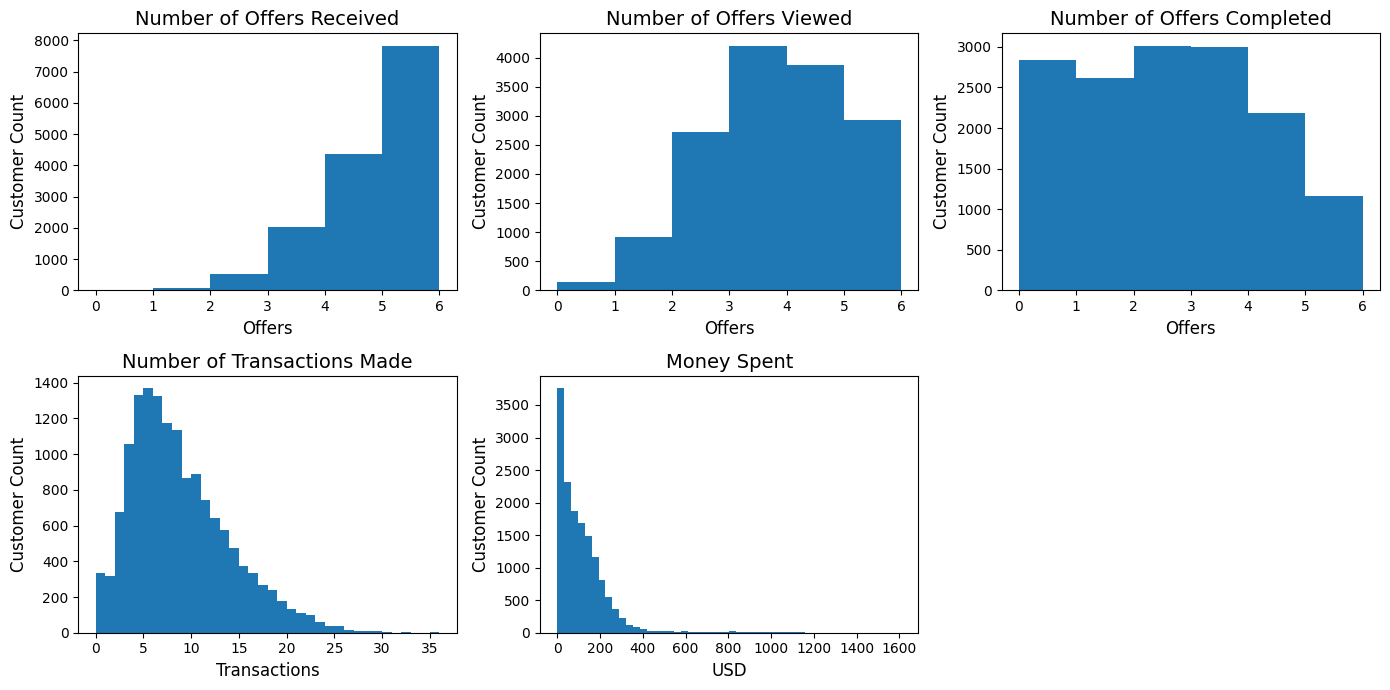

In [66]:
# Check the features with plots
fig, axs = plt.subplots(2,3, figsize = (14, 7))
fig_titles = ['Number of Offers Received', 'Number of Offers Viewed', 'Number of Offers Completed', 'Number of Transactions Made', 'Money Spent']
x_labels = ['Offers', 'Offers','Offers','Transactions','USD']
y_labels = 'Customer Count'

sub_row, sub_col = 0, 0

for i in range(5):
    if i < 3:
        sub_row = 0
        sub_col = i
        bins = customer_behavior.iloc[:, i].max()
        axs[sub_row, sub_col].hist(customer_behavior.iloc[:, i], bins = bins)
        axs[sub_row, sub_col].set_ylabel(y_labels, fontsize = 12)

    else:
        sub_row = 1
        sub_col = i - 3
        if i == 3:
            bins = customer_behavior.iloc[:, i].max()
            axs[sub_row, sub_col].hist(customer_behavior.iloc[:, i], bins = bins)
            axs[sub_row, sub_col].set_ylabel(y_labels, fontsize = 12)
        else:
            bins = 50
            axs[sub_row, sub_col].hist(customer_behavior.iloc[:, i], bins = bins)
            axs[sub_row, sub_col].set_ylabel(y_labels, fontsize = 12)
    
    axs[sub_row, sub_col].set_title(fig_titles[i], fontsize = 14)
    axs[sub_row, sub_col].set_xlabel(x_labels[i], fontsize = 12)

axs[1,2].set_axis_off()
plt.tight_layout()
plt.show()

Preparing df customer_behavior for clustering

Drop column num_received

I am going to be using features about customer behavior for clustering analysis. However, number of offers received was not actively decided by customers, therfore I will drop it when running clustering.



In [67]:
# Keep a copy of the df with `num_received`
customer_behavior_with_num_received = customer_behavior.copy()

# Drop `num_received`
customer_behavior.drop('num_received', axis = 1, inplace = True)
customer_behavior.head(3)

,num_viewed,num_completed,num_transactions,money_spent
person,,,,
0009655768c64bdeb2e877511632db8f,4,3,8,127.60
0011e0d4e6b944f998e987f904e8c1e5,5,3,5,79.46
0020c2b971eb4e9188eac86d93036a77,3,3,8,196.86


Remove outliers

From the plots above, feature money_spent is clearly skewed by outliers, I will look into it.

In [68]:
customer_behavior['money_spent'].describe()

count    14825.000000
mean       117.028155
std        129.965016
min          0.000000
25%         31.450000
50%         87.040000
75%        160.900000
max       1608.690000
Name: money_spent, dtype: float64

In [69]:
# Remove rows with top 2% in `money_spent`
q = customer_behavior['money_spent'].quantile(0.98)
rows_top_money_spent = customer_behavior[customer_behavior['money_spent'] >= q]

person_top_money_spent = rows_top_money_spent.index.values
customer_top_money_spent_removed = customer_behavior[customer_behavior['money_spent'] < q]

print('Number of rows removed:', rows_top_money_spent.shape[0])

Number of rows removed: 297


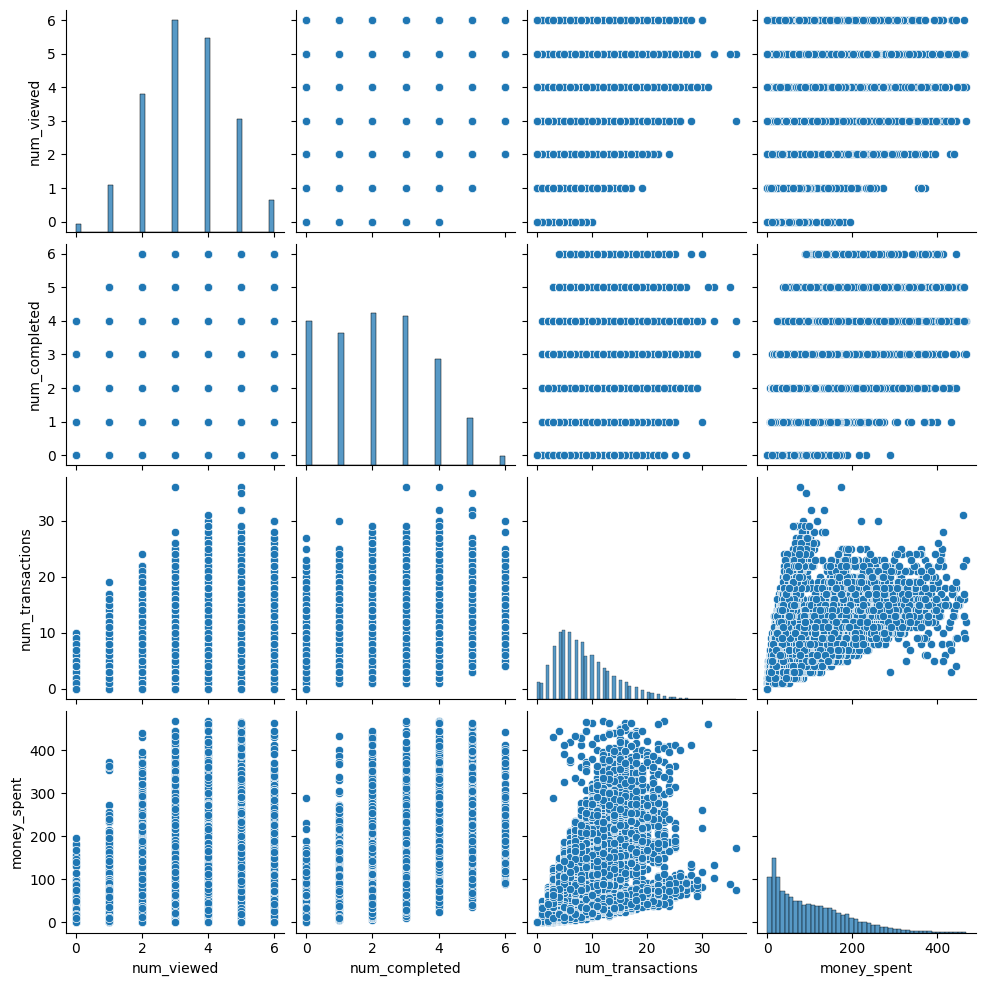

In [70]:
customer_behavior_filtered = customer_top_money_spent_removed.copy()
sns.pairplot(customer_behavior_filtered); plt.show()

**Feature Scaling**

The features are of different order of magnitudes, therefore need to be standardized.

In [71]:
#K-Means Clustering

scaler_customer_behavior = StandardScaler()
scaler_customer_behavior.fit(customer_behavior_filtered)
customer_behavior_scaled = scaler_customer_behavior.transform(customer_behavior_filtered)
pd.DataFrame(data = customer_behavior_scaled, columns = customer_behavior_filtered.columns.values).head(3)

,num_viewed,num_completed,num_transactions,money_spent
0,0.501233,0.531352,-0.060069,0.277234
1,1.276977,0.531352,-0.639666,-0.281415
2,-0.274511,0.531352,-0.060069,1.080974


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

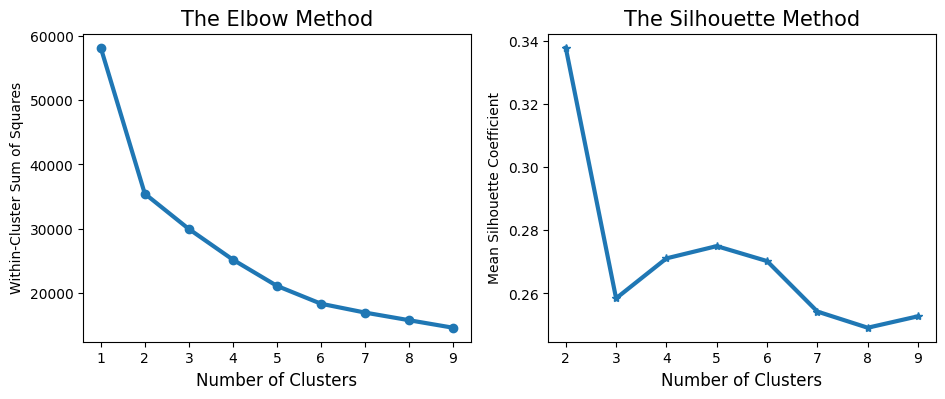

In [72]:
#Optimal number of clusters k

df_feature = customer_behavior_scaled
wcss = []
sil_score = []
max_clusters = 10

for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters = k, random_state = 10)
    kmeans.fit(df_feature)
    # calculate wcss for the Elbow Method
    wcss.append(kmeans.inertia_)
    
    # calculate the mean Silhouette coefficient
    if k >= 2:
        labels = kmeans.labels_
        sil_score.append(metrics.silhouette_score(df_feature, labels))

        # Plot
fig, axs = plt.subplots(1,2, figsize = (11,4))
axs[0].plot(np.arange(1, max_clusters), wcss, marker = 'o', lw = 3)
axs[0].set_xlabel('Number of Clusters', fontsize = 12)
axs[0].set_ylabel('Within-Cluster Sum of Squares')
axs[0].set_title('The Elbow Method', fontsize = 15)

axs[1].plot(np.arange(2, max_clusters), sil_score, marker = '*' , lw = 3)
axs[1].set_xlabel('Number of Clusters', fontsize = 12)
axs[1].set_ylabel('Mean Silhouette Coefficient')
axs[1].set_title('The Silhouette Method', fontsize = 15)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster
0    4018
1    2901
2    2649
3    1584
4    3376
dtype: int64

 ************************************************************
Silhouette Score: 0.274991463208214

 ************************************************************
        num_viewed num_completed num_transactions money_spent
              mean          mean             mean        mean
cluster                                                      
0              2.1           0.7              5.0        34.6
1              4.5           4.1             12.2       223.0
2              4.5           1.5              4.5        50.3
3              3.5           2.0             17.1        72.2
4              2.8           2.9              7.7       140.2


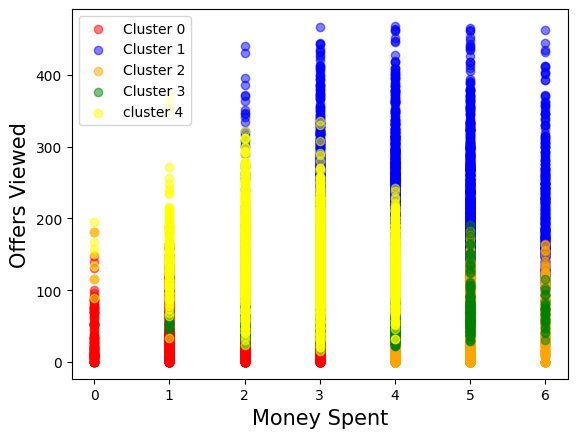

In [73]:
#K-Means Clustering

k = 5
df_feature = customer_behavior_scaled
kmeans = KMeans(n_clusters = k, random_state = 10)
kmeans.fit_transform(df_feature)
customer_with_cluster = customer_behavior_filtered.assign(cluster = kmeans.labels_)
print(customer_with_cluster.value_counts('cluster').sort_index())

line_sep = '*' * 60
print('\n', line_sep)
print('Silhouette Score:', metrics.silhouette_score(df_feature, labels = kmeans.labels_))

#
cluster_info = customer_with_cluster.groupby('cluster').agg([np.mean])
print('\n', line_sep)
print(cluster_info.round(1))

# Plot
color_list = ['red', 'blue', 'orange', 'green', 'yellow']
legend_list = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'cluster 4']
for i in range(k):
    plt.scatter(customer_with_cluster.loc[customer_with_cluster['cluster'] == i , 'num_viewed'],
               customer_with_cluster.loc[customer_with_cluster['cluster'] == i , 'money_spent'],
               c = color_list[i], label = legend_list[i], alpha = 0.5)
plt.ylabel('Offers Viewed', fontsize = 15)
plt.xlabel('Money Spent', fontsize = 15)
plt.legend(legend_list)
plt.show()

**Observations**

Although the Silhouette score is quite low (0.275), clusters can be identified when plotted using money_spent and num_viewed. Next, I will check the clusters visually in more details by plotting the them in separated subplots.

**Assessing the clustering results**

Here I will use two classification methods to conduct an (indirect) assessment of the clustering results. The labelled cluster (0, 1, 2, 3, 4) will be used as target and customer behavior features used in clustering analysis will be used as inputs.

In [74]:
#Classification with Multiclass Logistic Regression
# Split data for train and test
X = customer_behavior_scaled
Y = customer_with_cluster['cluster']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)

In [75]:
# Multiclass logistic regression
clf = LogisticRegression()
clf.fit(x_train, y_train)

# Check test accurracy
y_predict = clf.predict(x_test)
print("Test accuracy:", metrics.accuracy_score(y_test, y_predict))

Test accuracy: 0.993805918788713


In [76]:
#Classification with K-Nearest Neighbors
# K-Nearest Neighbors Classificaiton
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(x_train, y_train)

# Check test accuracy
y_predict = knn.predict(x_test)
print("Test accuracy:", metrics.accuracy_score(y_test, y_predict))


Test accuracy: 0.9855471438403304


**Clustering Result Visualization & Interpretation**

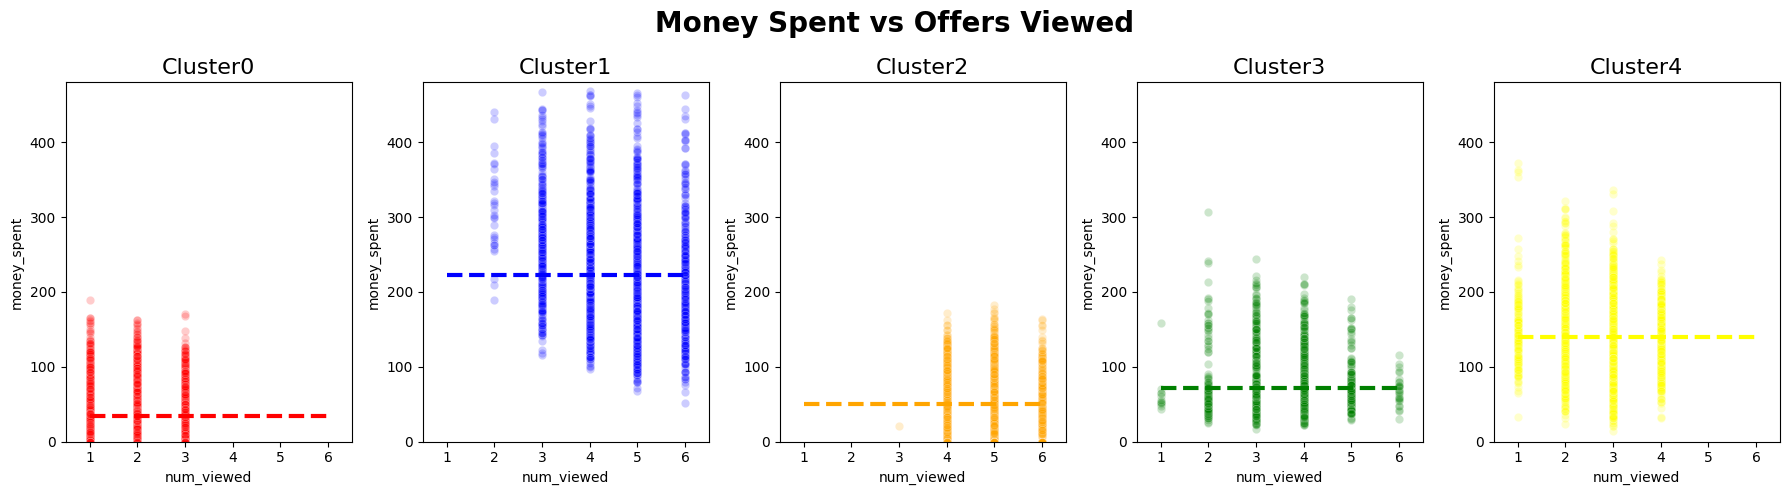

In [77]:
#Visualize clusters separately

fig, axs = plt.subplots(1, k, figsize = (18,5))
for i in range(k):
    sns.scatterplot(data = customer_with_cluster[customer_with_cluster['cluster'] == i],
                   x = 'num_viewed', y = 'money_spent', alpha = 0.2, color = color_list[i], ax = axs[i])
    
    mean_value = customer_with_cluster[customer_with_cluster['cluster'] == i].agg({'money_spent': 'mean'})
    axs[i].plot(np.arange(1, 7), (np.ones((1, 6))*mean_value.values).reshape((6,-1)), 
                color = color_list[i], lw =3, linestyle = 'dashed')
    axs[i].set_title('Cluster' + str(i), fontsize = 16)
    axs[i].set_xlim((0.5,6.5))
    axs[i].set_ylim((0,480))
fig.suptitle('Money Spent vs Offers Viewed', fontsize = 20, fontweight = 'bold')
plt.tight_layout()
plt.show()

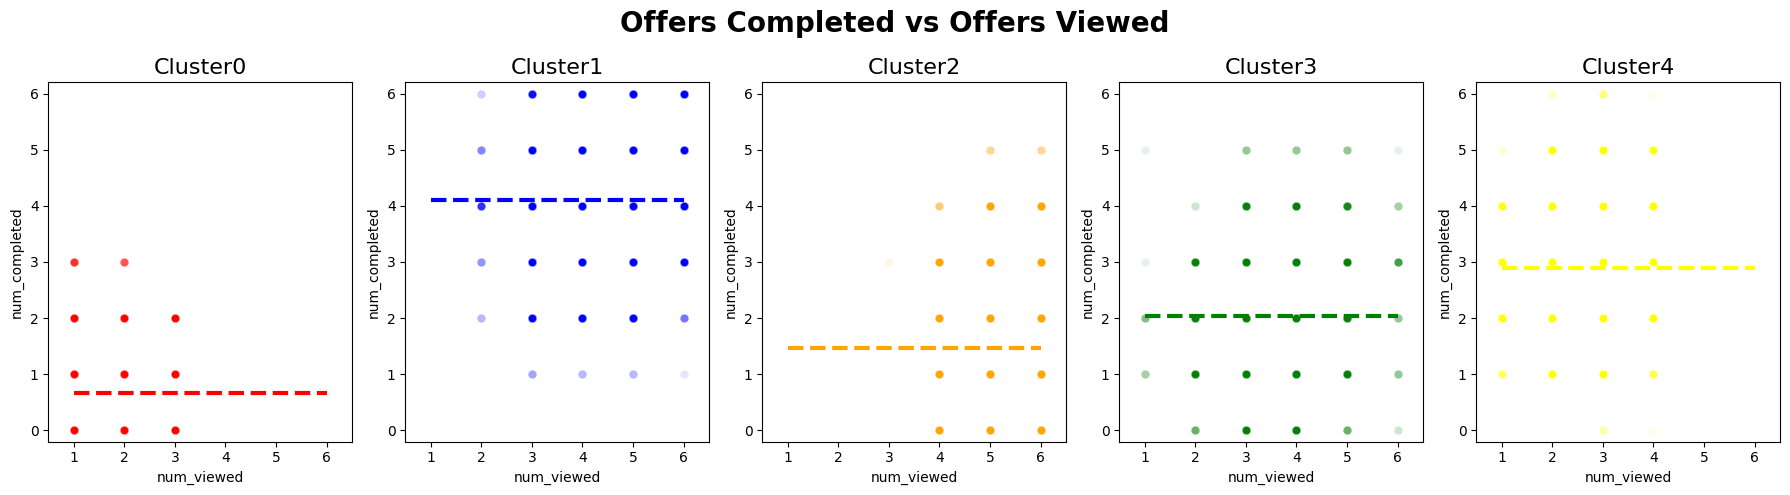

In [78]:
fig, axs = plt.subplots(1, k, figsize = (18,5))
for i in range(k):
    sns.scatterplot(data = customer_with_cluster[customer_with_cluster['cluster'] == i],
                   x = 'num_viewed', y = 'num_completed', alpha = 0.1, color = color_list[i], ax = axs[i])
    
    mean_value = customer_with_cluster[customer_with_cluster['cluster'] == i].agg({'num_completed': 'mean'})
    axs[i].plot(np.arange(1, 7), (np.ones((1, 6))*mean_value.values).reshape((6,-1)), 
                color = color_list[i], lw =3, linestyle = 'dashed')
    axs[i].set_title('Cluster' + str(i), fontsize = 16)
    axs[i].set_xlim((0.5,6.5))
    axs[i].set_ylim((-0.2,6.2))
fig.suptitle('Offers Completed vs Offers Viewed', fontsize = 20, fontweight = 'bold')
plt.tight_layout()
plt.show()

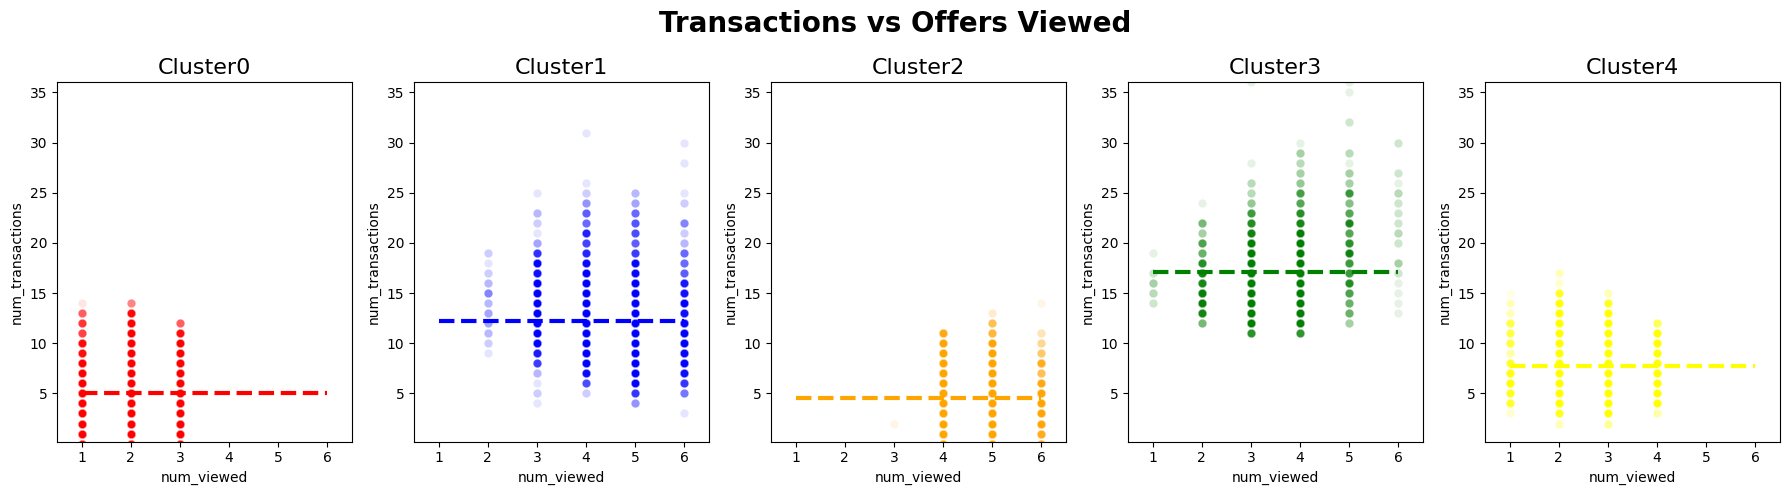

In [79]:
fig, axs = plt.subplots(1, k, figsize = (18,5))
for i in range(k):
    sns.scatterplot(data = customer_with_cluster[customer_with_cluster['cluster'] == i],
                   x = 'num_viewed', y = 'num_transactions', alpha = 0.1, color = color_list[i], ax = axs[i])
    
    mean_value = customer_with_cluster[customer_with_cluster['cluster'] == i].agg({'num_transactions': 'mean'})
    axs[i].plot(np.arange(1, 7), (np.ones((1, 6))*mean_value.values).reshape((6,-1)), 
                color = color_list[i], lw =3, linestyle = 'dashed')
    axs[i].set_title('Cluster' + str(i), fontsize = 16)
    axs[i].set_xlim((0.5,6.5))
    axs[i].set_ylim((0.2,36))
fig.suptitle('Transactions vs Offers Viewed', fontsize = 20, fontweight = 'bold')
plt.tight_layout()
plt.show()

**Observations:**

Note the dashed lines are the average values of each cluster.

Differences are clear from all three pair-wise features plots. This reflects the clustering is effective even the Silhouette score is low.

**Relative performace of each cluster in each field**

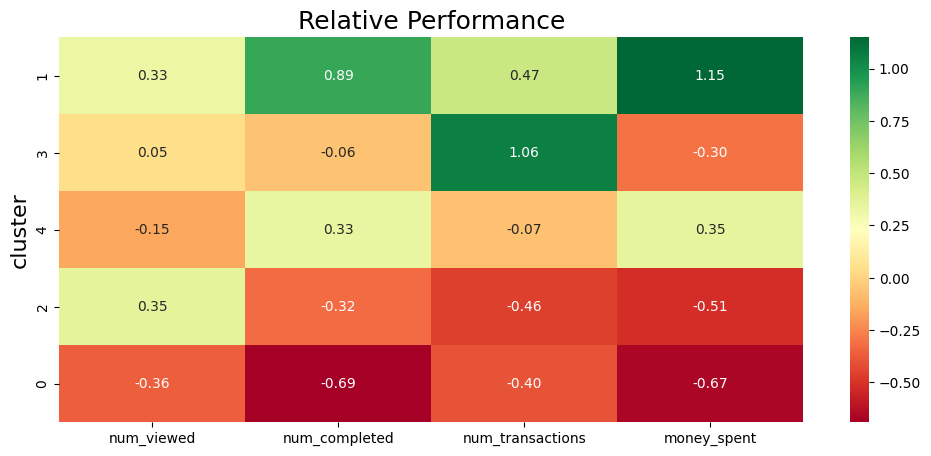

In [80]:
# Calculate the relative performace of cluster's attribute values compared to all customers as a population
cluster_mean = customer_with_cluster.groupby('cluster').mean()
population_mean = customer_with_cluster.mean()
relative_importance = (cluster_mean / population_mean[0 :-1]) - 1

# Sort clusters by overall (summation) performance
importance_ranking = relative_importance.sum(axis = 1).sort_values(ascending = False).index.values
relative_importance = relative_importance.reindex(importance_ranking)

# Plot the heatmap
plt.figure(figsize = (12, k))
plt.title('Relative Performance', fontsize = 18)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('Cluster', fontsize = 16)
sns.heatmap(data = relative_importance, annot = True, fmt = '.2f', cmap = 'RdYlGn')
plt.show()

**Key Metrics of each cluster**

To better understand customer behavior of each segment and to guide segment-specific strategies, key metrics interested are:

Frequency - Number of transactions made during the month of campaign

Average Purchase Value - Average number of dollars spent on each transaction

Offer Complete Rate - Offer overall completion rate

Sensitivity to Offer - Proportion of transactions made with offers (calculated as num_completed divided by num_transactions)

In [81]:
# Calculated the mean of all features for each cluster
temp = pd.merge(customer_with_cluster, customer_behavior_with_num_received['num_received'], left_index = True, right_index = True)
cluster_means = temp.groupby('cluster').mean().round(3)
cluster_means = cluster_means.reindex(importance_ranking)
cluster_means

,num_viewed,num_completed,num_transactions,money_spent,num_received
cluster,,,,,
1,4.452,4.096,12.223,222.970,5.094
3,3.512,2.028,17.098,72.242,4.674
4,2.845,2.887,7.744,140.156,4.150
2,4.541,1.463,4.529,50.347,5.029
0,2.143,0.671,4.992,34.568,3.881


In [82]:
# Create the df for summarizing by clusters
cluster_summary = pd.DataFrame(columns = ['cluster', 'frequency', 'avg_purchase_value', 'offer_complete_rate', 'offer_sensitivity'])
cluster_summary['cluster'] = index = np.arange(k)
cluster_summary.set_index('cluster', drop = True, inplace = True)

In [83]:
# Add values to df `cluster_summary`
cluster_summary['frequency'] = cluster_means['num_transactions'].round(1)
cluster_summary['avg_purchase_value'] = (cluster_means['money_spent'] / cluster_means['num_transactions']).round(1)
cluster_summary['offer_complete_rate'] = (cluster_means['num_completed'] / cluster_means['num_received']).round(2)
cluster_summary['offer_sensitivity'] = (cluster_means['num_completed'] / cluster_means['num_transactions']).round(2)

In [84]:
# Redorder index
cluster_summary = cluster_summary.reindex(importance_ranking)
cluster_summary

,frequency,avg_purchase_value,offer_complete_rate,offer_sensitivity
cluster,,,,
1,12.2,18.2,0.80,0.34
3,17.1,4.2,0.43,0.12
4,7.7,18.1,0.70,0.37
2,4.5,11.1,0.29,0.32
0,5.0,6.9,0.17,0.13


**Customer demographics of each cluster**

In [85]:
# Scale features
rows_top_money_spent_scaled = scaler_customer_behavior.transform(rows_top_money_spent)

# Have a direct look at the clustering result
kmeans.predict(rows_top_money_spent_scaled)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int3

In [86]:
cluster_kmeans = kmeans.predict(rows_top_money_spent_scaled)
unique_element, counter = np.unique(cluster_kmeans, return_counts = True)

print('According to the KMeans model, customers spending top 2% belong to:')
for i in range(len(unique_element)):
    print('{} customers belongs to Cluster {}.'.format(counter[i], unique_element[i]))

According to the KMeans model, customers spending top 2% belong to:
295 customers belongs to Cluster 1.
2 customers belongs to Cluster 4.


Use the trained logistic regression model to decide which cluster the 2% customes belong

In [87]:
cluster_logistic = clf.predict(rows_top_money_spent_scaled)
unique_element, counter = np.unique(cluster_logistic, return_counts = True)

print('According to the Logistic Regression model, customers spending top 2% belong to:')
for i in range(len(unique_element)):
    print('{} customers belongs to Cluster {}.'.format(counter[i], unique_element[i]))

According to the Logistic Regression model, customers spending top 2% belong to:
293 customers belongs to Cluster 1.
4 customers belongs to Cluster 4.


Use the trained KNN model to decide which cluster the 2% customes belong

In [88]:
cluster_KNN = knn.predict(rows_top_money_spent_scaled)
unique_element, counter = np.unique(cluster_KNN, return_counts = True)

print('According to the KNN model, customers spending top 2% belong to:')
for i in range(len(unique_element)):
    print('{} customers belongs to Cluster {}.'.format(counter[i], unique_element[i]))

According to the KNN model, customers spending top 2% belong to:
297 customers belongs to Cluster 1.


According to all three models, more 98.5% of customers who spent top 2% belong to culster 1 (Most Valuable Customers). I will then add all of them to cluster 1 for simplisity.

**Add top 2% spenders to cluster 1 (Most Valuable Customers)**

In [89]:
# Concatenate top 2% spenders with the rest of the customers (behavior)
customer_behavior_clustered = temp[rows_top_money_spent.columns.values]
customer_behavior_clustered = customer_behavior_clustered.assign(cluster = temp['cluster'])
customer_behavior_clustered = pd.concat([customer_behavior_clustered, rows_top_money_spent], axis = 0)

# Assign these customers to cluster 1
customer_behavior_clustered.fillna(value = 1, inplace = True)

# Convert cluster label from float to integers
customer_behavior_clustered['cluster'] = customer_behavior_clustered['cluster'].astype('int')

In [90]:
#Merge customer_behavior_clustered with customers
# Reset index for `customer_behavior_clustered`
customer_behavior_clustered.reset_index(inplace = True)
# Merge
customer_behavior_profile = pd.merge(customer_behavior_clustered, customers,
                                    left_on = 'person', right_on = 'id').drop(['id'], axis = 1)

In [91]:
# Add column `cluster_alias`
customer_behavior_profile['cluster_alias'] = customer_behavior_profile['cluster'].map({1: 'Most-Valables',
                                                                                       3: 'Regulars',
                                                                                       4: 'High-Potentials',
                                                                                       2: 'Offer-Viewers',
                                                                                       0: 'Low-Engagers'})
customer_behavior_profile.head(3)

,person,num_viewed,num_completed,num_transactions,money_spent,cluster,gender,age,became_member_on,income,age_group,income_group,cluster_alias
0,0009655768c64bdeb2e877511632db8f,4,3,8,127.60,4,M,33,2017-04-21,72000.0,26-35ys,60-75k,High-Potentials
1,0011e0d4e6b944f998e987f904e8c1e5,5,3,5,79.46,2,O,40,2018-01-09,57000.0,36-45ys,45-60k,Offer-Viewers
2,0020c2b971eb4e9188eac86d93036a77,3,3,8,196.86,4,F,59,2016-03-04,90000.0,56-65ys,75-90k,High-Potentials


**Customer demographics of each segment**


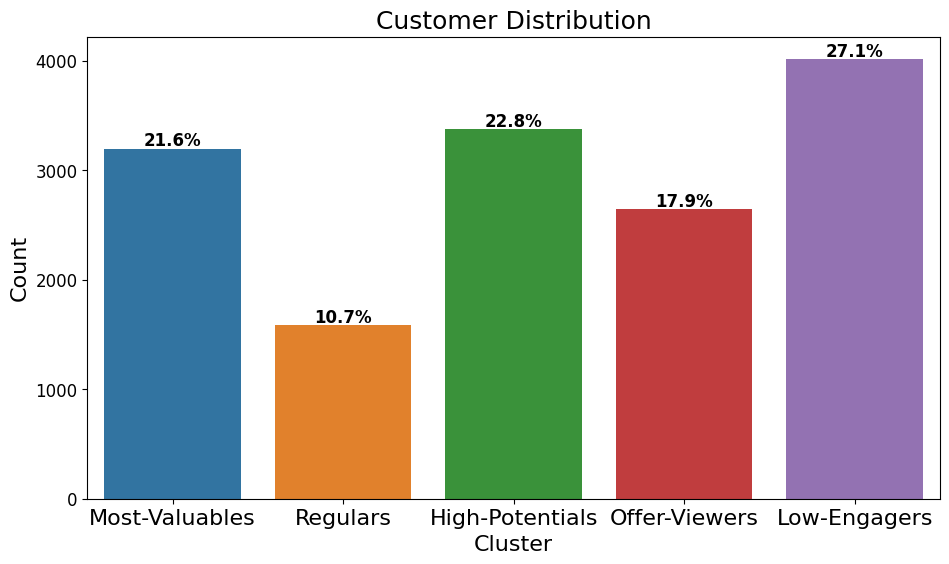

In [92]:
#Number of customers in each segment
p = customer_behavior_profile.value_counts('cluster').reindex(importance_ranking)
cluster_pct = list((p/p.sum() * 100).round(2))
cluster_names = ['Most-Valuables', 'Regulars', 'High-Potentials', 'Offer-Viewers', 'Low-Engagers']
fig = plt.figure(figsize = (11,6))
ax = sns.barplot(x = p.index.values, y = p.values, order = importance_ranking)
patches = ax.patches
for i in range(len(p)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height() + 25
    ax.annotate(text = '{:.1f}%'.format(cluster_pct[i]), xy = (x, y), ha = 'center',
               fontsize = 12, weight = 'bold')
    
plt.title('Customer Distribution', fontsize = 18)
plt.xticks(ticks = np.arange(len(p)), labels = cluster_names, fontsize = 16)
plt.yticks(ticks = np.arange(0, 5000, 1000), fontsize = 12)
plt.xlabel('Cluster', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.show()

In [93]:
#Average demographics of each segment
segment_means = customer_behavior_profile.groupby('cluster').agg({'age': 'mean', 'income': 'mean'}).reindex(importance_ranking)
segment_means.index = ['Most-Valuables', 'Regulars', 'High-Potentials', 'Offer-Viewers', 'Low-Engagers']
segment_means.round(2).head()

,age,income
Most-Valuables,56.10,71735.46
Regulars,47.33,48782.83
High-Potentials,57.93,74534.66
Offer-Viewers,55.53,65218.95
Low-Engagers,52.10,59371.08


**Observations**

The High-Potentials segement are highest in both age and income. The Most-Valuables segement comes right after.

The Regelars segement are the lowest in both age and income.

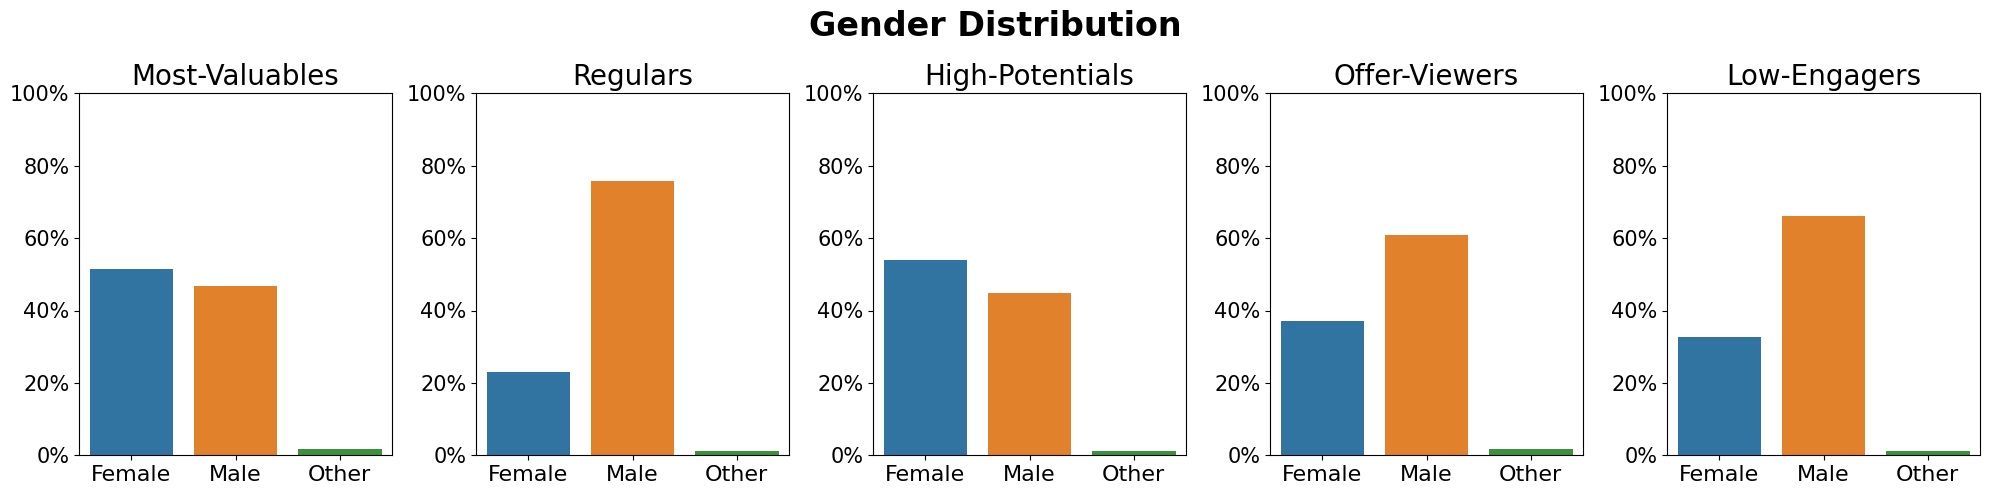

In [94]:
#Gender distribution in each segment
num_clusters = customer_behavior_profile['cluster'].nunique()
fig, axs = plt.subplots(1, num_clusters, figsize = (20,5))
cluster_names = ['Most-Valuables', 'Regulars', 'High-Potentials', 'Offer-Viewers', 'Low-Engagers']
xticklabels = ['Female', 'Male', 'Other']
yticks = np.arange(0,1.2, 0.2)
yticklabels = [str(n) + '%' for n in (yticks * 100).astype(int)]
for i in np.arange(num_clusters):
    p = customer_behavior_profile[customer_behavior_profile['cluster'] == importance_ranking[i]].value_counts('gender').sort_index()
    sns.barplot(x = p.index.values, y = p.values / p.sum(), ax = axs[i])
    axs[i].set_title(cluster_names[i], fontsize = 20)
    axs[i].set_xticklabels(xticklabels, fontsize = 16)
    axs[i].set_yticks(yticks); axs[i].set_yticklabels(yticklabels, fontsize = 15)

plt.suptitle('Gender Distribution', fontsize = 24, fontweight = 'bold')
plt.tight_layout()
plt.show()

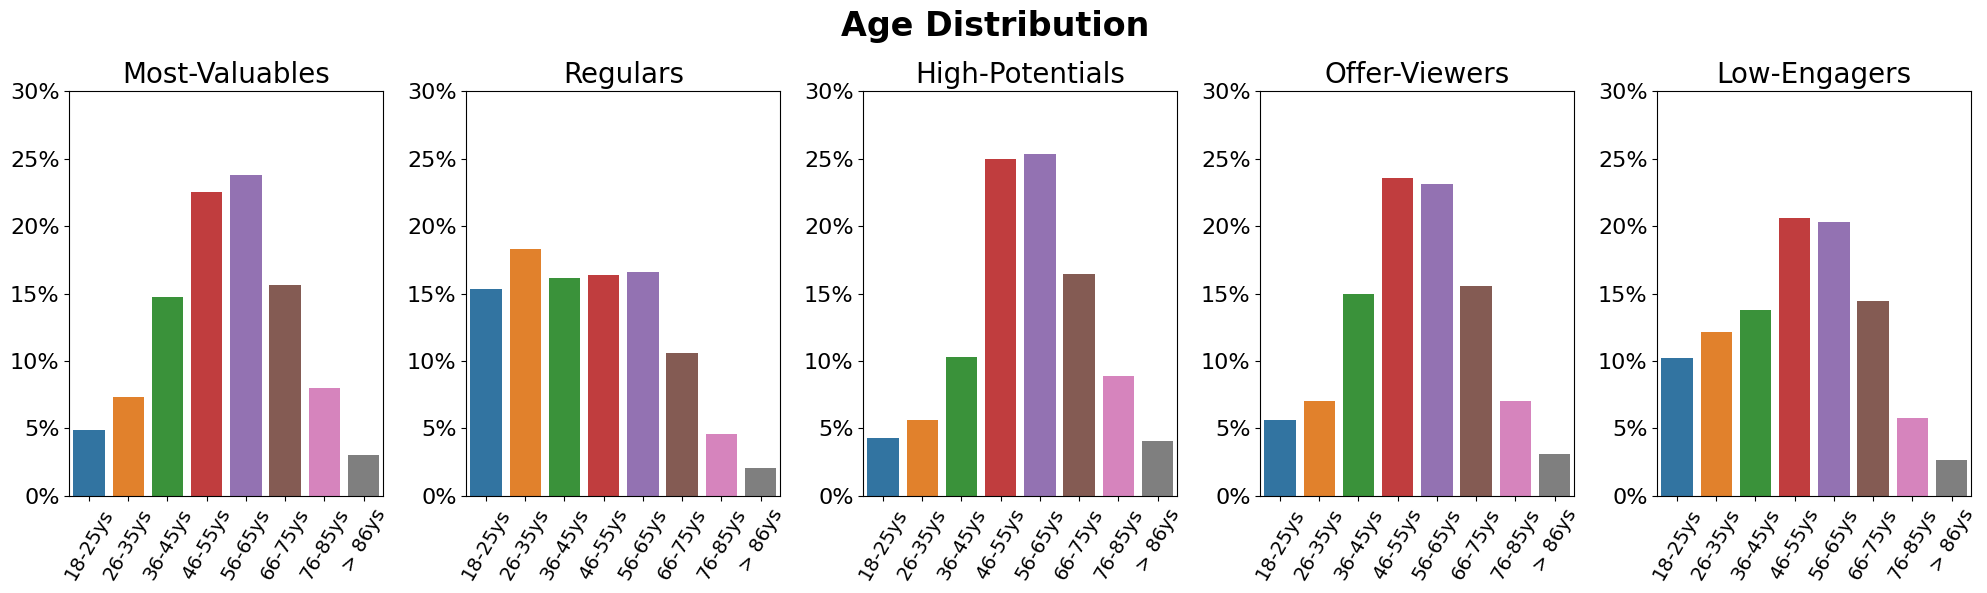

In [95]:
#Age distribution in each segment
fig, axs = plt.subplots(1, num_clusters, figsize = (20,6))
cluster_names = ['Most-Valuables', 'Regulars', 'High-Potentials', 'Offer-Viewers', 'Low-Engagers']
age_group_list = ['18-25ys', '26-35ys', '36-45ys', '46-55ys', '56-65ys', '66-75ys', '76-85ys', '> 86ys']
yticks = np.arange(0,0.35, 0.05)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

for i in np.arange(num_clusters):
    p = customer_behavior_profile[customer_behavior_profile['cluster'] == importance_ranking[i]].value_counts('age_group').sort_index()
    sns.barplot(x = p.index.values, y = p.values / p.sum(), ax = axs[i])
    axs[i].set_title(cluster_names[i], fontsize = 20)
    axs[i].set_yticks(yticks); axs[i].set_yticklabels(ytick_labels, fontsize = 16)
    axs[i].set_xticklabels(age_group_list, rotation=60, fontsize = 14)

plt.suptitle('Age Distribution', fontsize = 24, fontweight = 'bold')
plt.tight_layout()
plt.show()

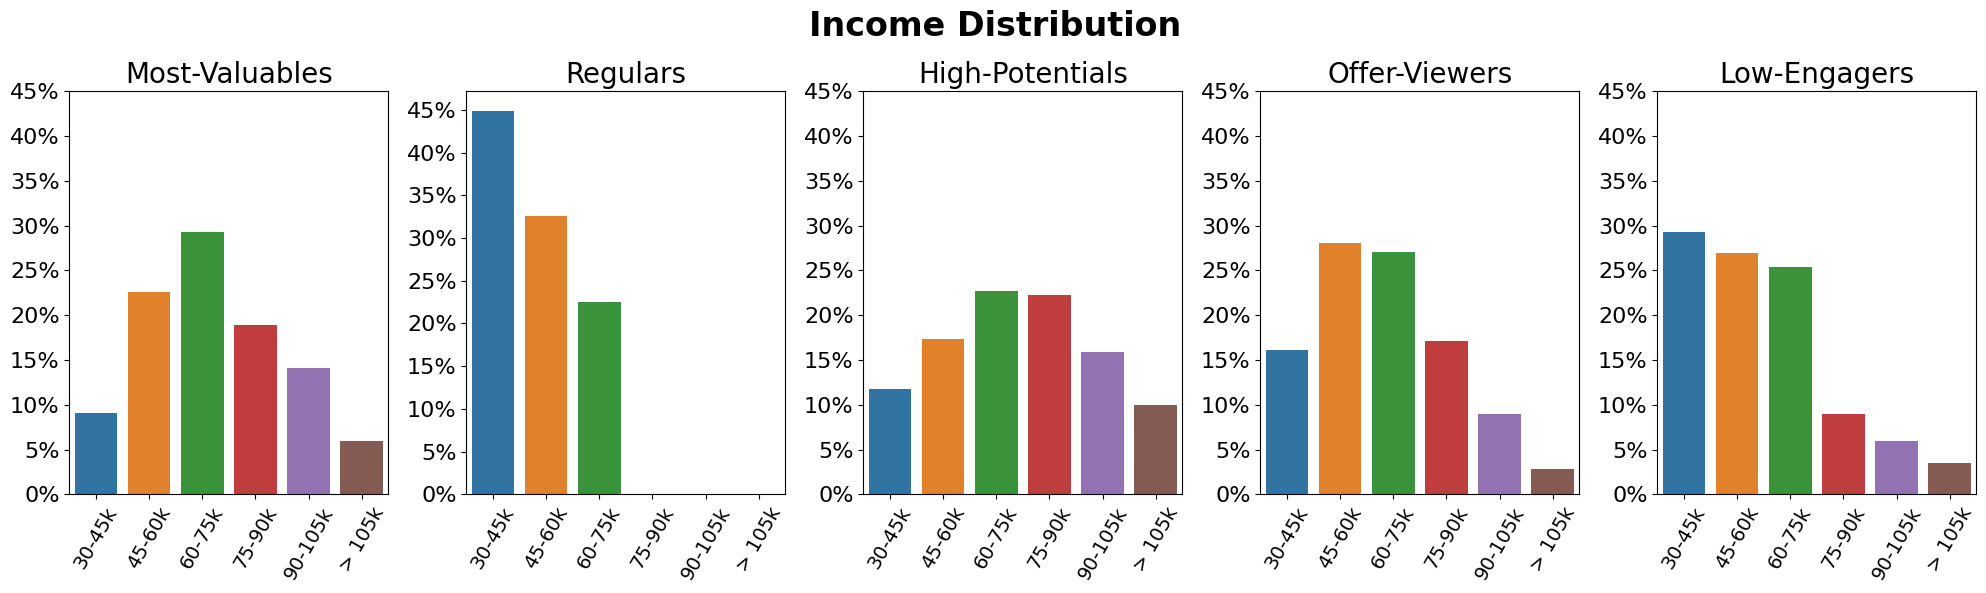

In [96]:
#Income distribution in each segment
fig, axs = plt.subplots(1, num_clusters, figsize = (20,6))
cluster_names = ['Most-Valuables', 'Regulars', 'High-Potentials', 'Offer-Viewers', 'Low-Engagers']
income_group_list = ['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '> 105k']
yticks = np.arange(0,0.5, 0.05)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]
for i in np.arange(num_clusters):
    p = customer_behavior_profile[customer_behavior_profile['cluster'] == importance_ranking[i]].value_counts('income_group').sort_index()
    sns.barplot(x = p.index.values, y = p.values / p.sum(), ax = axs[i])
    axs[i].set_title(cluster_names[i], fontsize = 20)
    axs[i].set_yticks(yticks); axs[i].set_yticklabels(ytick_labels, fontsize = 16)
    axs[i].set_xticklabels(income_group_list[: p.shape[0]], rotation=60, fontsize = 14)

plt.suptitle('Income Distribution', fontsize = 24, fontweight = 'bold')
plt.tight_layout()
plt.show()

**Summary on demographics of each segment**

Most Valuable Customers between 36-75 years old, having an income between 45-90k. Slightly more females than male.

Regulars Lower-Income males evenly distributed within 18-65 years old, having an income between 30-75k.

High Potentials between 46-75 years old. Income 60-90k. Similar number of females and males.

Offer-Viewers age and income are both rougly normaly distributed. Slightly more males than female.

Low Engager Mostly males on the lower half of the income spectrum.



**How customer attributes affected their response to offers?**

In [97]:
#Merge dfs customers and event_offer
# Add column `channel_alias` for easier referencing
event_offer['channel_alias'] = event_offer['channels'].map({
    "['web', 'email', 'mobile', 'social']": 1,
    "['email', 'mobile', 'social']": 2,
    "['web', 'email', 'mobile']": 3,
    "['web', 'email']": 4
})

In [98]:
# Merge
event_offer_customer = pd.merge(customers, event_offer, left_on = 'id', right_on = 'person').drop('id', axis = 1)

# Drop unwanted columns
event_offer_customer.drop(['channels', 'dict_key'], axis = 1, inplace = True)

# Reorder columns
col_names = ['gender', 'age', 'became_member_on', 'income', 'age_group', 'income_group', 'person', 
             'event', 'offer_alias', 'channel_alias', 'offer_type',
             'reward', 'difficulty', 'duration',
             'hours_since_start', 'days_since_start'
       ]
event_offer_customer = event_offer_customer[col_names]
event_offer_customer.head(3)

,gender,age,became_member_on,income,age_group,income_group,person,event,offer_alias,channel_alias,offer_type,reward,difficulty,duration,hours_since_start,days_since_start
0,F,55,2017-07-15,112000.0,46-55ys,> 105k,0610b486422d4921ae7d2bf64640c50b,offer received,A,3,bogo,5,5,7,408,17
1,F,55,2017-07-15,112000.0,46-55ys,> 105k,0610b486422d4921ae7d2bf64640c50b,offer completed,A,3,bogo,5,5,7,528,22
2,F,55,2017-07-15,112000.0,46-55ys,> 105k,0610b486422d4921ae7d2bf64640c50b,offer received,I,3,informational,0,0,4,504,21


**How gender influenced cutomer response to offers?**

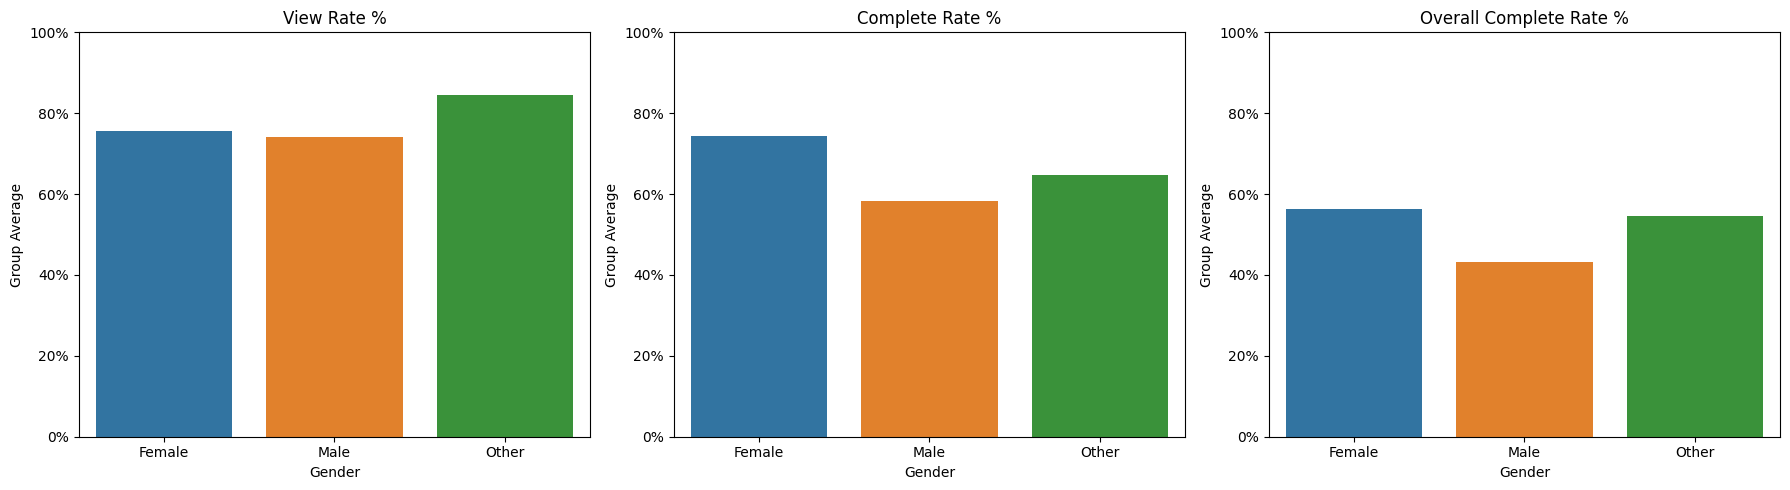

In [99]:
# Group data
grouped_by_gender = event_offer_customer.groupby(['gender', 'event']).agg({'hours_since_start': 'count'})
gender_list = ['F', 'M', 'O']

# Calculate view rate
view_rate = []
for i in range(len(gender_list)):
    view_rate.append(grouped_by_gender.loc[(gender_list[i], 'offer viewed')] / grouped_by_gender.loc[(gender_list[i], 'offer received')])
view_rate = [x[0] for x in view_rate]

# Calculate complete rate
complete_rate = []
for i in range(len(gender_list)):
    complete_rate.append(grouped_by_gender.loc[(gender_list[i], 'offer completed')] / grouped_by_gender.loc[(gender_list[i], 'offer viewed')])
complete_rate = [x[0] for x in complete_rate]

# Calculate overall complete rate
overall_complete_rate = []
for i in range(len(gender_list)):
    overall_complete_rate.append(grouped_by_gender.loc[(gender_list[i], 'offer completed')] / grouped_by_gender.loc[(gender_list[i], 'offer received')])
overall_complete_rate = [x[0] for x in overall_complete_rate]

# Visualize
xticks = np.arange(len(gender_list))
xticklabels = ['Female', 'Male', 'Other']
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

fig, axs = plt.subplots(1, 3, figsize = (18, 5))
sns.barplot(x = xticks, y = view_rate, ax = axs[0])
sns.barplot(x = xticks, y = complete_rate, ax = axs[1])
sns.barplot(x = xticks, y = overall_complete_rate, ax = axs[2])
axs[0].set_title('View Rate %'); axs[0].set_xlabel('Gender'); axs[0].set_ylabel('Group Average')
axs[0].set_xticklabels(xticklabels); axs[0].set_yticks(yticks); axs[0].set_yticklabels(ytick_labels)
axs[1].set_title('Complete Rate %'); axs[1].set_xlabel('Gender'); axs[1].set_ylabel('Group Average')
axs[1].set_xticklabels(xticklabels); axs[1].set_yticks(yticks); axs[1].set_yticklabels(ytick_labels)
axs[2].set_title('Overall Complete Rate %'); axs[2].set_xlabel('Gender'); axs[2].set_ylabel('Group Average')
axs[2].set_xticklabels(xticklabels); axs[2].set_yticks(yticks); axs[2].set_yticklabels(ytick_labels)

plt.tight_layout()
plt.show()

Observations

View Rate: Customers of other genders had the highest view rate (84.4%). Female customers came second with a slightly higher view rate (75.7%) than male customers (74.2%).

Completion Rate: Having viewed the offers, female customers were most likely to complete them, presenting the highest completion rate of 74.5%. This is followed by customers of other gender with a completion rate of 64.8%. Male customers were the least likely to complete offers with a completion rate of 58.2%.

Overall completion rate: Overall, female customers completed the highest percentage (56.4%) of offers they received, closely followed by customers of other genders (54.7%). Male customers had the lowest offer completion rate (43.2%).

Summary
Overall, female cutomers were more likely to complete offers they received than other genders, having an overall compeltion rate of 56.4%. Especially, there was a very high chance (74.5%) for them to complete an offer as long as they have viewed it. Therefore, increasing view rate of female customers will effectively increase the overall compeltion rate. Male customers are the least responsive to offers, having the lowest rates.

**How age influenced cutomer response to offers?**

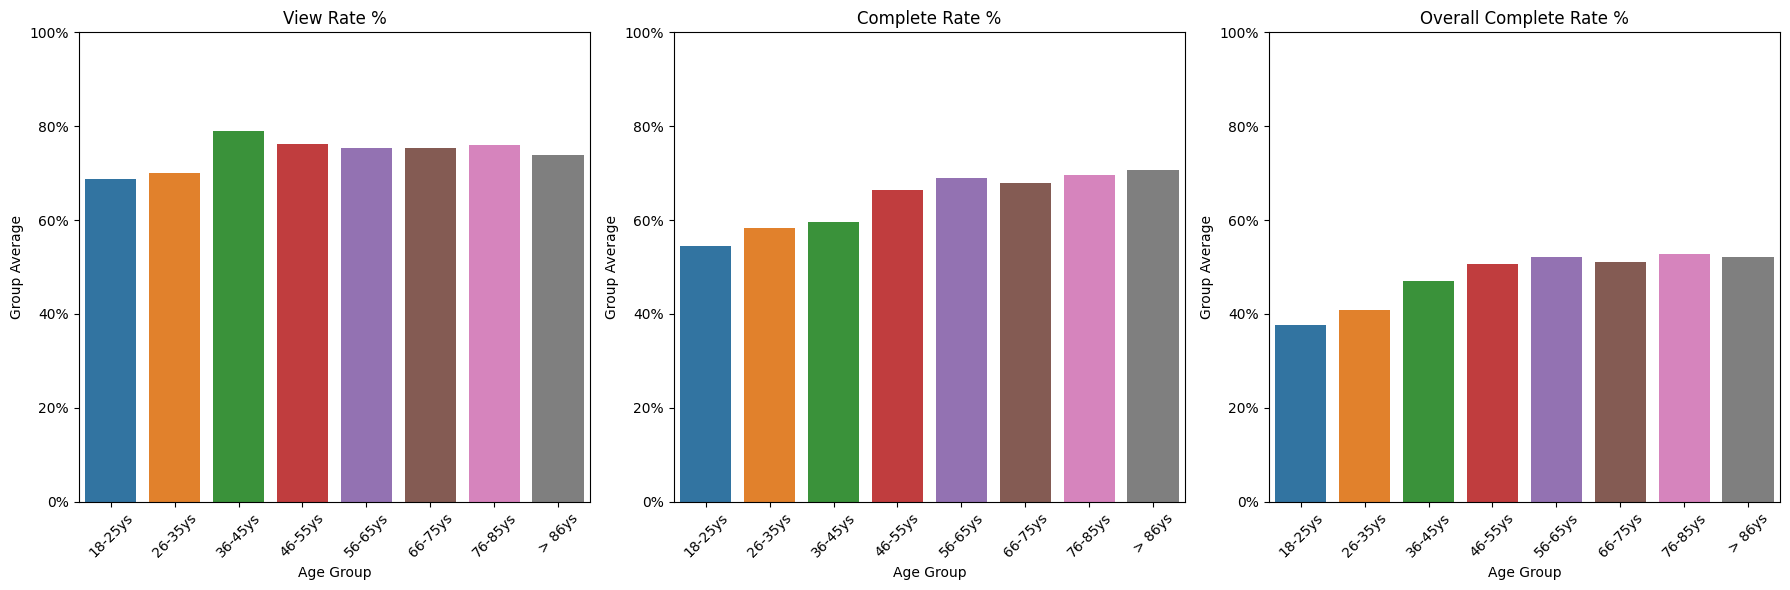

In [100]:
# Group data
grouped_by_age = event_offer_customer.groupby(['age_group', 'event']).agg({'hours_since_start': 'count'})
age_group_list = ['18-25ys', '26-35ys', '36-45ys', '46-55ys', '56-65ys', '66-75ys', '76-85ys', '> 86ys']

# Calculate view rate
view_rate = []
for i in range(len(age_group_list)):
    view_rate.append(grouped_by_age.loc[(age_group_list[i], 'offer viewed')] / grouped_by_age.loc[(age_group_list[i], 'offer received')])
view_rate = [x[0] for x in view_rate]

# Calculate complete rate
complete_rate = []
for i in range(len(age_group_list)):
    complete_rate.append(grouped_by_age.loc[(age_group_list[i], 'offer completed')] / grouped_by_age.loc[(age_group_list[i], 'offer viewed')])
complete_rate = [x[0] for x in complete_rate]

# Calculate overall complete rate
overall_complete_rate = []
for i in range(len(age_group_list)):
    overall_complete_rate.append(grouped_by_age.loc[(age_group_list[i], 'offer completed')] / grouped_by_age.loc[(age_group_list[i], 'offer received')])
overall_complete_rate = [x[0] for x in overall_complete_rate]

# Visualize
xticks = np.arange(len(age_group_list))
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

fig, axs = plt.subplots(1, 3, figsize = (18, 6))
sns.barplot(x = np.arange(len(age_group_list)), y = view_rate, ax = axs[0])
sns.barplot(x = np.arange(len(age_group_list)), y = complete_rate, ax = axs[1])
sns.barplot(x = np.arange(len(age_group_list)), y = overall_complete_rate, ax = axs[2])
axs[0].set_title('View Rate %'); axs[0].set_xlabel('Age Group'); axs[0].set_ylabel('Group Average')
axs[0].set_xticklabels(age_group_list, rotation=45); axs[0].set_yticks(yticks); axs[0].set_yticklabels(ytick_labels)
axs[1].set_title('Complete Rate %'); axs[1].set_xlabel('Age Group'); axs[1].set_ylabel('Group Average')
axs[1].set_xticklabels(age_group_list, rotation=45); axs[1].set_yticks(yticks); axs[1].set_yticklabels(ytick_labels)
axs[2].set_title('Overall Complete Rate %'); axs[2].set_xlabel('Age Group'); axs[2].set_ylabel('Group Average')
axs[2].set_xticklabels(age_group_list, rotation=45); axs[2].set_yticks(yticks); axs[2].set_yticklabels(ytick_labels)

plt.tight_layout()
plt.show()

**Observations**

Trends accross different age groups are weak. This means that age is not a very important factor that affects cutomer's response to offers.

In general, younger custerms were less responsive to offers then elder ones.

There is a gentle increase in overall completion rate % with age for customers between 18 - 65 years old, from 38% to 52%. After 65 years old, the overall completion rate keeps almost unchanged with change in age.

**How income influenced cutomer response to offers?**

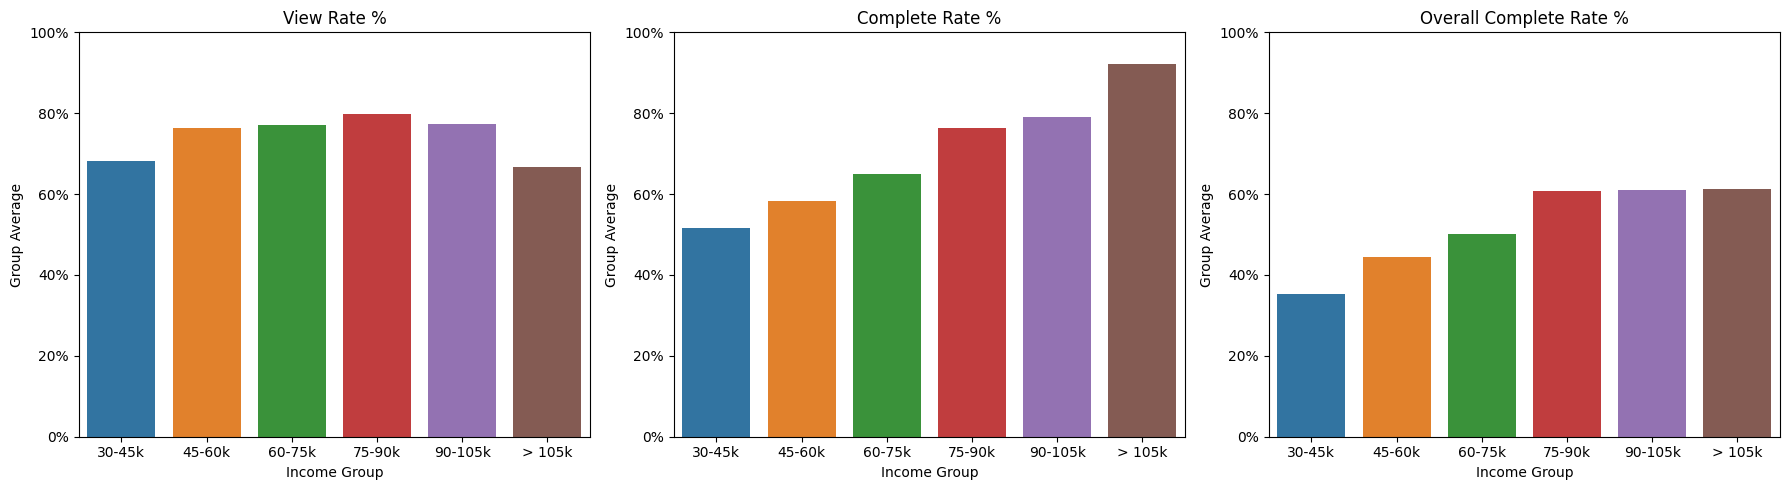

In [101]:
# Group data
grouped_by_income = event_offer_customer.groupby(['income_group', 'event']).agg({'hours_since_start': 'count'})
income_group_list = ['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '> 105k']

# Calculate view rate
view_rate = []
for i in range(len(income_group_list)):
    view_rate.append(grouped_by_income.loc[(income_group_list[i], 'offer viewed')] / grouped_by_income.loc[(income_group_list[i], 'offer received')])
view_rate = [x[0] for x in view_rate]

# Calculate complete rate
complete_rate = []
for i in range(len(income_group_list)):
    complete_rate.append(grouped_by_income.loc[(income_group_list[i], 'offer completed')] / grouped_by_income.loc[(income_group_list[i], 'offer viewed')])
complete_rate = [x[0] for x in complete_rate]

# Calculate overall complete rate
overall_complete_rate = []
for i in range(len(income_group_list)):
    overall_complete_rate.append(grouped_by_income.loc[(income_group_list[i], 'offer completed')] / grouped_by_income.loc[(income_group_list[i], 'offer received')])
overall_complete_rate = [x[0] for x in overall_complete_rate]

# Visualize
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

fig, axs = plt.subplots(1, 3, figsize = (18, 5))
sns.barplot(x = np.arange(len(income_group_list)), y = view_rate, ax = axs[0])
sns.barplot(x = np.arange(len(income_group_list)), y = complete_rate, ax = axs[1])
sns.barplot(x = np.arange(len(income_group_list)), y = overall_complete_rate, ax = axs[2])
axs[0].set_title('View Rate %'); axs[0].set_xlabel('Income Group'); axs[0].set_ylabel('Group Average')
axs[0].set_xticklabels(income_group_list); axs[0].set_yticks(yticks); axs[0].set_yticklabels(ytick_labels)
axs[1].set_title('Complete Rate %'); axs[1].set_xlabel('Income Group'); axs[1].set_ylabel('Group Average')
axs[1].set_xticklabels(income_group_list); axs[1].set_yticks(yticks); axs[1].set_yticklabels(ytick_labels)
axs[2].set_title('Overall Complete Rate %'); axs[2].set_xlabel('Income Group'); axs[2].set_ylabel('Group Average')
axs[2].set_xticklabels(income_group_list); axs[2].set_yticks(yticks); axs[2].set_yticklabels(ytick_labels)

plt.tight_layout()
plt.show()

**Observations**

Trends accross different income groups are stronger than that accross different age groups. This means income is a more important factor that affects customer response to offers than age.

View rate % shows a soft reversed U-shape, with a range of 68% - 80%. Customers in 75-90k income groups were most likely to view offers received, while cutomers in the lowest (30-45k) and highest (>105k) income groups were least likely to view.

Completion rate % (of offers viewed) shows a very clear trend that it increases steadily with income. From the lowest to the highest income group, the average completion rate increased from 52% to 92%.

The overall completion rate % is the result of the two trends described above combined (multiplied). It increases steadlily with income for income between 30-90k, from 35% to 61%, and keeps unchanged with further increase in income.

**How offer attributes affected customer behavior for different cutomer groups?**

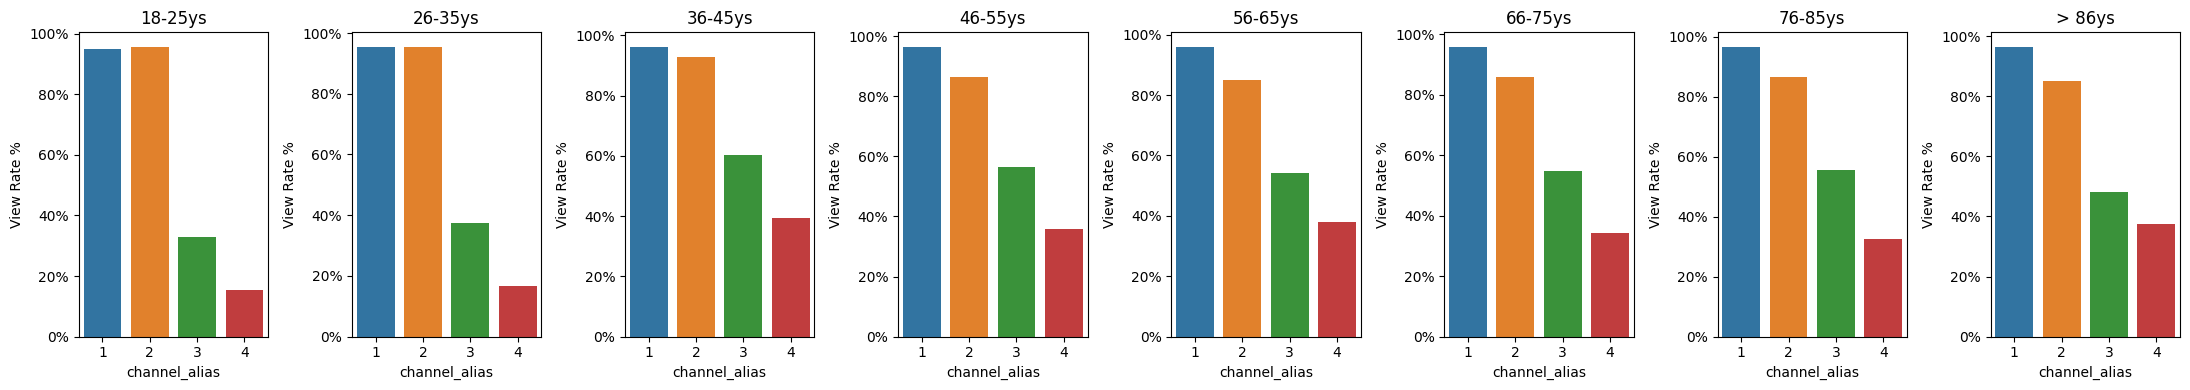

In [102]:
#How promotion channel affected view rate % in different age_group?
# Group data
grouped_by_age = event_offer_customer.groupby(['age_group', 'event','channel_alias']).agg({'hours_since_start': 'count'})

# Visualize
age_group_list = ['18-25ys', '26-35ys', '36-45ys', '46-55ys', '56-65ys', '66-75ys', '76-85ys', '> 86ys']
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

fig, axs = plt.subplots(1, len(age_group_list), figsize = (22,4))
for i in range(len(age_group_list)):
    p = (grouped_by_age.loc[(age_group_list[i], 'offer viewed')] / grouped_by_age.loc[(age_group_list[i], 'offer received')]).sort_index()
    p.rename(columns = {'hours_since_start': 'Percentage %'}, inplace = True)
    p.reset_index(inplace = True)
    
    sns.barplot(data = p, x = 'channel_alias', y = 'Percentage %', ax = axs[i])
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(ytick_labels)
    axs[i].set_title(age_group_list[i])
    axs[i].set_ylabel('View Rate %')
    
plt.tight_layout()
plt.show()

**How promotion channel affected view rate % in different gender?**

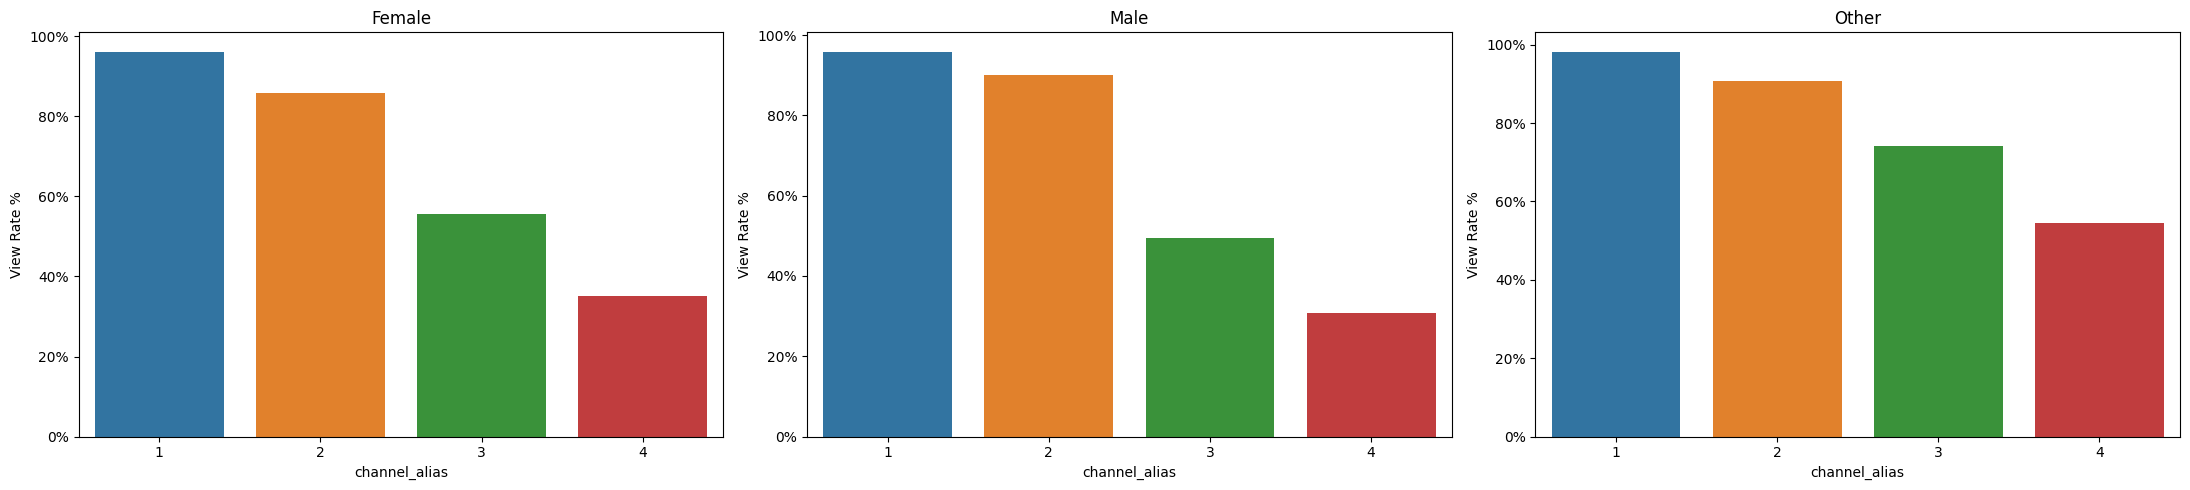

In [103]:
# Group data
grouped_by_gender = event_offer_customer.groupby(['gender', 'event','channel_alias']).agg({'hours_since_start': 'count'})

# Visualize
gender_list = ['F', 'M', 'O']
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]
title_list = ['Female', 'Male', 'Other']

fig, axs = plt.subplots(1, len(gender_list), figsize = (22,5))
for i in range(len(gender_list)):
    p = (grouped_by_gender.loc[(gender_list[i], 'offer viewed')] / grouped_by_gender.loc[(gender_list[i], 'offer received')]).sort_index()
    p.rename(columns = {'hours_since_start': 'Percentage %'}, inplace = True)
    p.reset_index(inplace = True)
    
    sns.barplot(data = p, x = 'channel_alias', y = 'Percentage %', ax = axs[i])
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(ytick_labels)
    axs[i].set_title(title_list[i])
    axs[i].set_ylabel('View Rate %')
    
plt.tight_layout()
plt.show()

**Observations**

Female: for female customers, there was not dominating promotion channel. They preferred social media, but also viewed a decent number of offers through email and mobile, and some from the company's website. Their ranking is:
Social Media > Email >= Mobile > Website.

Male: male customers were most likely to view offers from social media. This may be partly becuase the company's male customers are on average the youngest among all genders, assuming young people are more likely to view offers from social media (shown above). Their ranking is:
Social Media >> Email > Mobile >> Website.

Other: cutomers of other genders showed a very different pattern. They viewed most offers through email. Mobile (Yellow - Green) comes next, and then social media (Blue - yellow) and website (Blue - Red). Their ranking is:
Email > Mobile > Social Media > Website.

**How promotion channel affected view rate % in different income_group?**


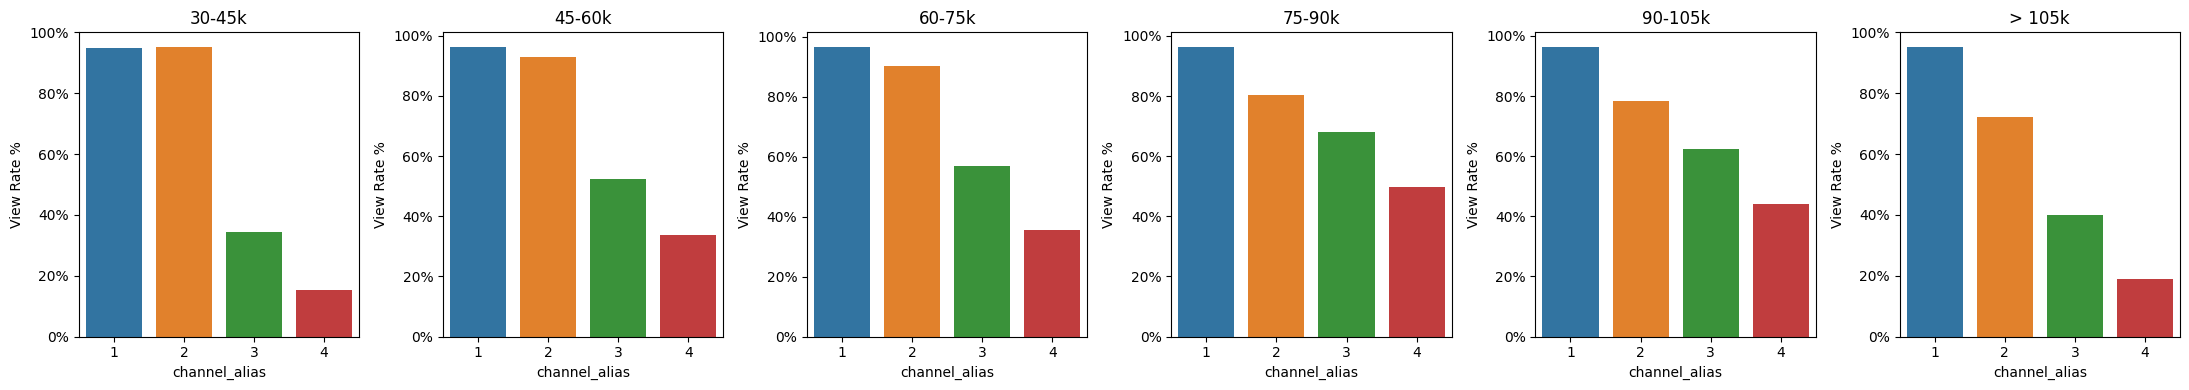

In [104]:
# Group data
grouped_by_income = event_offer_customer.groupby(['income_group', 'event','channel_alias']).agg({'hours_since_start': 'count'})

# Visualize
income_group_list = ['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '> 105k']
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

fig, axs = plt.subplots(1, len(income_group_list), figsize = (22,4))
for i in range(len(income_group_list)):
    p = (grouped_by_income.loc[(income_group_list[i], 'offer viewed')] / grouped_by_income.loc[(income_group_list[i], 'offer received')]).sort_index()
    p.rename(columns = {'hours_since_start': 'Percentage %'}, inplace = True)
    p.reset_index(inplace = True)
    
    sns.barplot(data = p, x = 'channel_alias', y = 'Percentage %', ax = axs[i])
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(ytick_labels)
    axs[i].set_title(income_group_list[i])
    axs[i].set_ylabel('View Rate %')
    
plt.tight_layout()
plt.show()
    

**Observations**

**Group 1 & 2 (Blue - Red -> Web)**
There is a clear trend that the higher income a customer has the more likely they viewed offers from the company's website.

**Group 1 & 3 (Blue - Yellow -> Social media)**
View rate shows a steady decreasing trend with income growth for income between 30 - 90k, and an increasing trend with income growth for incomes higher than 90k. A logical interpretation is that people gets busier with the growth of income upto 90k. After that their work (and maybe stage of life) may swift and require less time, so they tend to have more time for social media, therefore are more likely to view offers from there.

**Group 3 & 4 (Yellow - Green -> Mobile)**
Interstingly, views through mobile does not change much with customer income.
Group 4 alone (Green -> Email, taking views from web into account)
Customers viewed a decent number of offers through email, expect for those with lowest (30-45k) and highest (>105k) income.

**How offer_type affected the completion rate % for different age_group?**

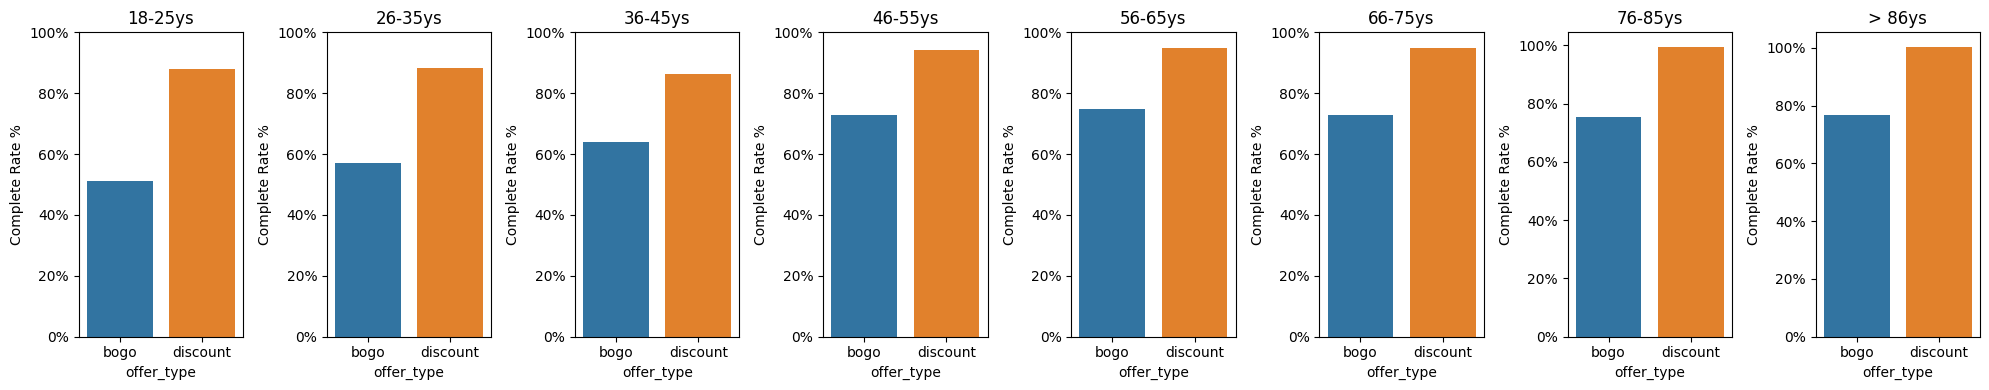

In [105]:
# Group data
grouped_by_age = event_offer_customer.groupby(['age_group', 'event','offer_type']).agg({'hours_since_start': 'count'})

# Visualize
age_group_list = ['18-25ys', '26-35ys', '36-45ys', '46-55ys', '56-65ys', '66-75ys', '76-85ys', '> 86ys']
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

fig, axs = plt.subplots(1, len(age_group_list), figsize = (20,4))
for i in range(len(age_group_list)):
    p = (grouped_by_age.loc[(age_group_list[i], 'offer completed')] / grouped_by_age.loc[(age_group_list[i], 'offer viewed')]).sort_index()
    p.rename(columns = {'hours_since_start': 'Percentage %'}, inplace = True)
    p.reset_index(inplace = True)
    
    sns.barplot(data = p.iloc[0:2,:], x = 'offer_type', y = 'Percentage %', ax = axs[i])
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(ytick_labels)
    axs[i].set_title(age_group_list[i])
    axs[i].set_ylabel('Complete Rate %')
    
plt.tight_layout()
plt.show()
    

**Observations**

'Discount' offers are preferred by customers in all age groups.

The two younger age groups are more sensitive to the offer type then other age groups.


**How offer_type affected the completion rate % for different gender?**

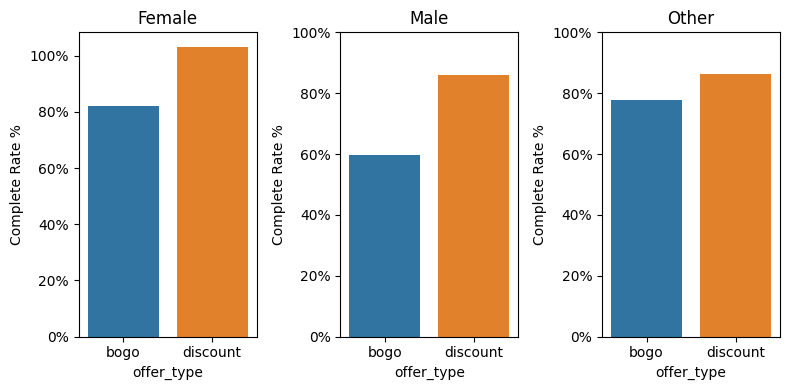

In [106]:
# Group data
grouped_by_gender = event_offer_customer.groupby(['gender', 'event','offer_type']).agg({'hours_since_start': 'count'})

# Visualize
gender_list = ['F', 'M', 'O']
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]
title_list = ['Female', 'Male', 'Other']

fig, axs = plt.subplots(1, len(gender_list), figsize = (8,4))
for i in range(len(gender_list)):
    p = (grouped_by_gender.loc[(gender_list[i], 'offer completed')] / grouped_by_gender.loc[(gender_list[i], 'offer viewed')]).sort_index()
    p.rename(columns = {'hours_since_start': 'Percentage %'}, inplace = True)
    p.reset_index(inplace = True)
    
    sns.barplot(data = p.iloc[0:2,:], x = 'offer_type', y = 'Percentage %', ax = axs[i])
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(ytick_labels)
    axs[i].set_title(title_list[i])
    axs[i].set_ylabel('Complete Rate %')
    
plt.tight_layout()
plt.show()

**Observations**

'Discount' offers are preferred by customers of all genders.

Cutomers of other genders are least sensitive to offer type.

**How offer_type affected the completion rate % for different income_group?**

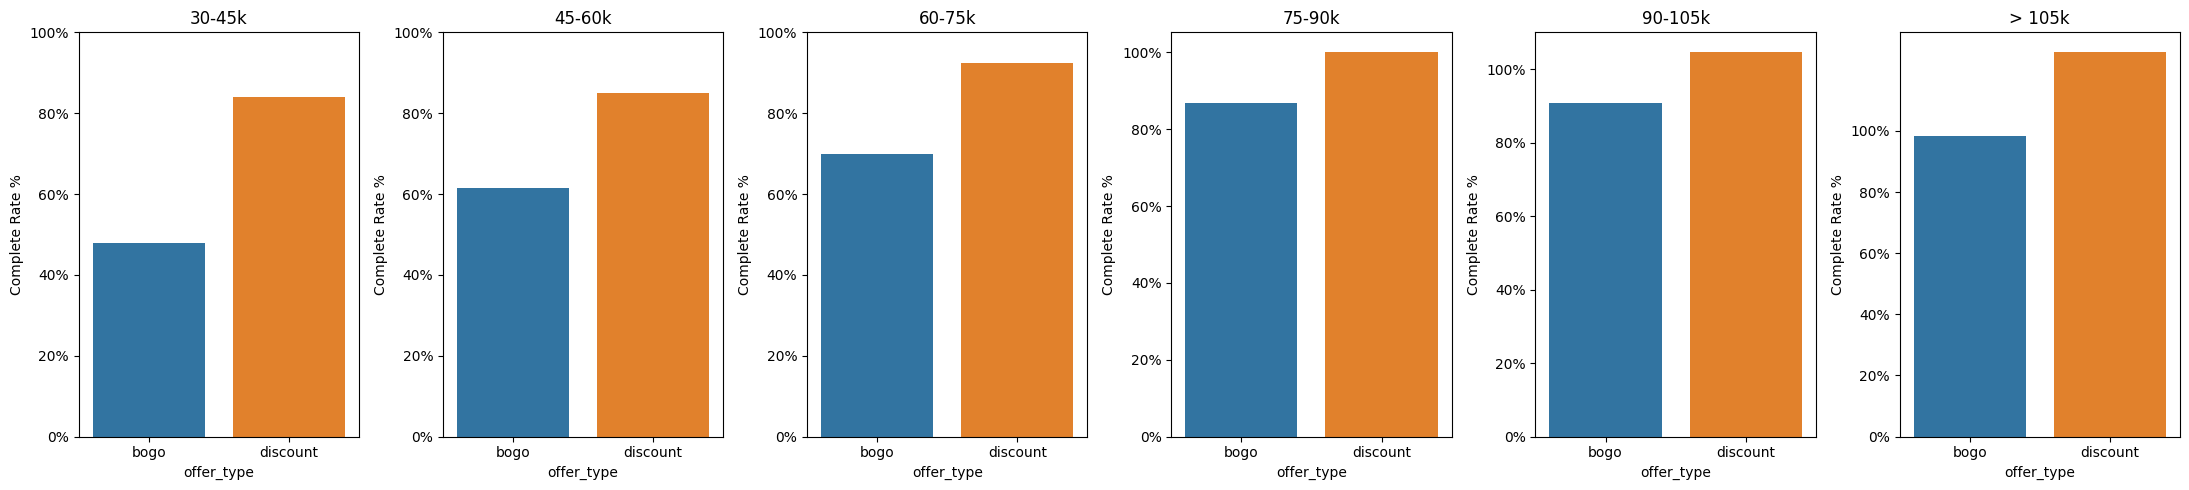

In [107]:
# Group data
grouped_by_income = event_offer_customer.groupby(['income_group', 'event','offer_type']).agg({'hours_since_start': 'count'})

# Visualize
income_group_list = ['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '> 105k']
yticks = np.arange(0,1.2, 0.2)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

fig, axs = plt.subplots(1, len(income_group_list), figsize = (22,5))
for i in range(len(income_group_list)):
    p = (grouped_by_income.loc[(income_group_list[i], 'offer completed')] / grouped_by_income.loc[(income_group_list[i], 'offer viewed')]).sort_index()
    p.rename(columns = {'hours_since_start': 'Percentage %'}, inplace = True)
    p.reset_index(inplace = True)
    
    sns.barplot(data = p.iloc[0:2,:], x = 'offer_type', y = 'Percentage %', ax = axs[i])
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(ytick_labels)
    axs[i].set_title(income_group_list[i])
    axs[i].set_ylabel('Complete Rate %')
    
plt.tight_layout()
plt.show()
    

Observations

'Discount' offers are preferred by customers in all income groups.
Customers in lower income groups are more sensitive to the offer type then those in higher income groups.